# Classification Task

## Dataset Description
### - NBA team records from Kesci.com
    - Data time : 1985/10/25 - 2016/06/19
    - Not every team has complete data during the period
        - EX. OKC Thunder : 2008/10/29 - 2016/04/12 (Precursor : 1967-2008 Seattle SuperSonics)
        - EX. BKN Nets : 2012/11/03 - 2016/04/13 (Precursor : 1077 - 2012 New Jersey Nets)
    - Lack of 2016-2018 seasion/playoff data
    - Link : https://www.kesci.com/apps/home/dataset/599a6e66c8d2787da4d1e21d
 
### - NBA team records from Stat-NBA.com
    - Data time : 2016/10/26 - 2018/06/08
    - Used to make up the lack of 2016-2018 season/playoff data
    - Link : http://www.stat-nba.com/



## Motivation
    - To know whether the favorite team will win a game or not.
    - To elevate the winning rate of sports lottery. We intend to increase pocket money while enjoying watching NBA.

## Problem Definition
#### The task is to use the playseason data to train a model to predict the result of games in the playoff of NBA 2017-2018. The training data is from 2017-08-01 to 2018-04-13. The testing data is from 2018-04-14 to 2018-06-01.
    - Input:  The attrubutes, which inlcudes FG%, FGM, FGA, 3P% ,...etc., of the two teams that are averaged by previous 5 games. The competition opponents of the previous 5 games are not necessary to be each other.
    - Output: The label that which team will win.

## Dataset Observation

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import time
import statistics
from sklearn.cluster import KMeans
from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 40, 35
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 25

# Dataset cleaner
def CleanDataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

def PrintStatistic(in_df):
    fig, ax = plt.subplots(figsize=(30, 70))
    plt.rcParams.update({'font.size': 25})
    fig.subplots_adjust(hspace=.3)

    numOfPlot = 18
    row = int(numOfPlot/2)
    col = 2
    kk = 1

    for item in in_df:
        if item == 'Date' or item == 'W/L' or item == 'Home/Away' or item == 'Score':
            continue
        else:
            plt.subplot(row, col, kk)
            in_df[item].hist(bins = 100)
            if item == 'Team':
                plt.xticks(rotation='vertical')
            plt.title(item)
            plt.ylabel('count')
            kk += 1
            if kk > numOfPlot:
                break

### Observe the play seasion data (1985-2018)

In [152]:
season = pd.read_csv("team_season_all.csv")
#Remove NaN
season = CleanDataset(season)
season.describe()

,FG%,FGM,FGA,3P%,3PM,3PA,FT%,FTM,FTA,REB,OREB,DREB,AST,STL,BLK,TOV,PF,PTS
count,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000,68458.000000
mean,0.459598,38.004645,82.843934,0.341954,5.521006,15.634988,0.754257,19.153759,25.401925,42.484837,12.087105,30.397733,22.595664,7.916518,5.034532,14.540755,21.836980,100.684084
std,0.057884,5.672364,8.292008,0.153172,3.606870,8.185048,0.099821,6.610457,8.165408,6.703747,4.338099,5.428779,5.496493,3.041724,2.678656,4.137524,4.751272,12.991094
min,0.234000,16.000000,53.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,17.000000,0.000000,10.000000,3.000000,0.000000,0.000000,2.000000,5.000000,49.000000
25%,0.420000,34.000000,77.000000,0.250000,3.000000,10.000000,0.692000,14.000000,20.000000,38.000000,9.000000,27.000000,19.000000,6.000000,3.000000,12.000000,19.000000,92.000000
50%,0.458000,38.000000,82.000000,0.333000,5.000000,15.000000,0.760000,19.000000,25.000000,42.000000,12.000000,30.000000,22.000000,8.000000,5.000000,14.000000,22.000000,100.000000
75%,0.500000,42.000000,88.000000,0.429000,8.000000,21.000000,0.824000,23.000000,31.000000,47.000000,15.000000,34.000000,26.000000,10.000000,7.000000,17.000000,25.000000,109.000000
max,0.697000,67.000000,130.000000,1.000000,25.000000,61.000000,1.000000,61.000000,80.000000,81.000000,38.000000,56.000000,52.000000,25.000000,24.000000,40.000000,52.000000,173.000000


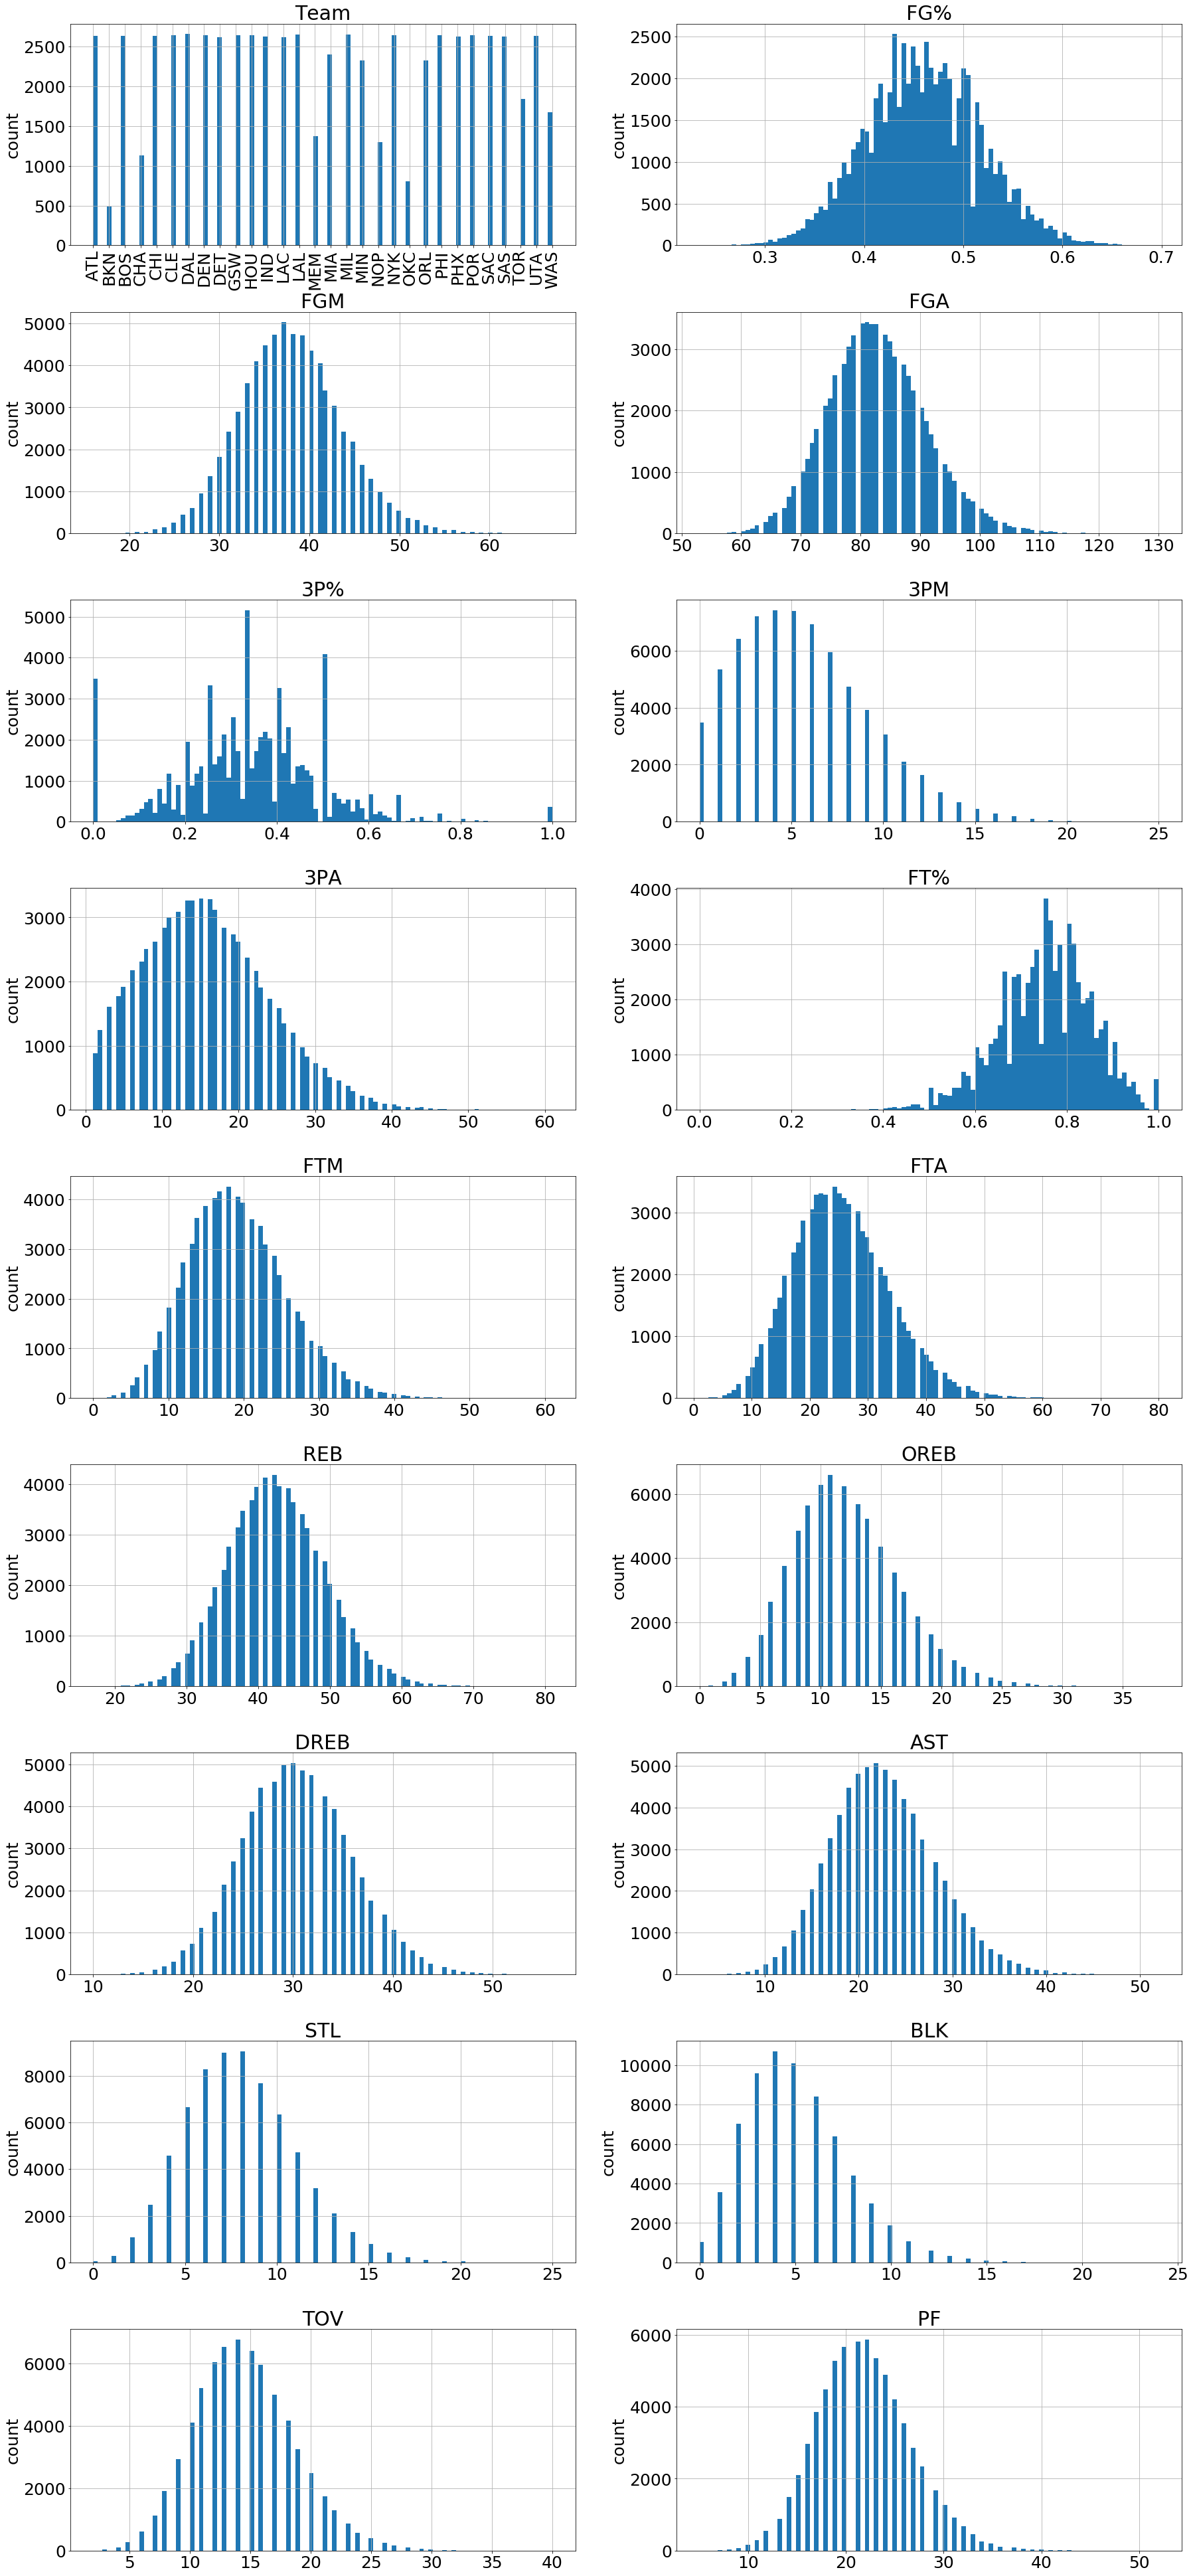

In [153]:
PrintStatistic(season)

Text(0,0.5,'count')

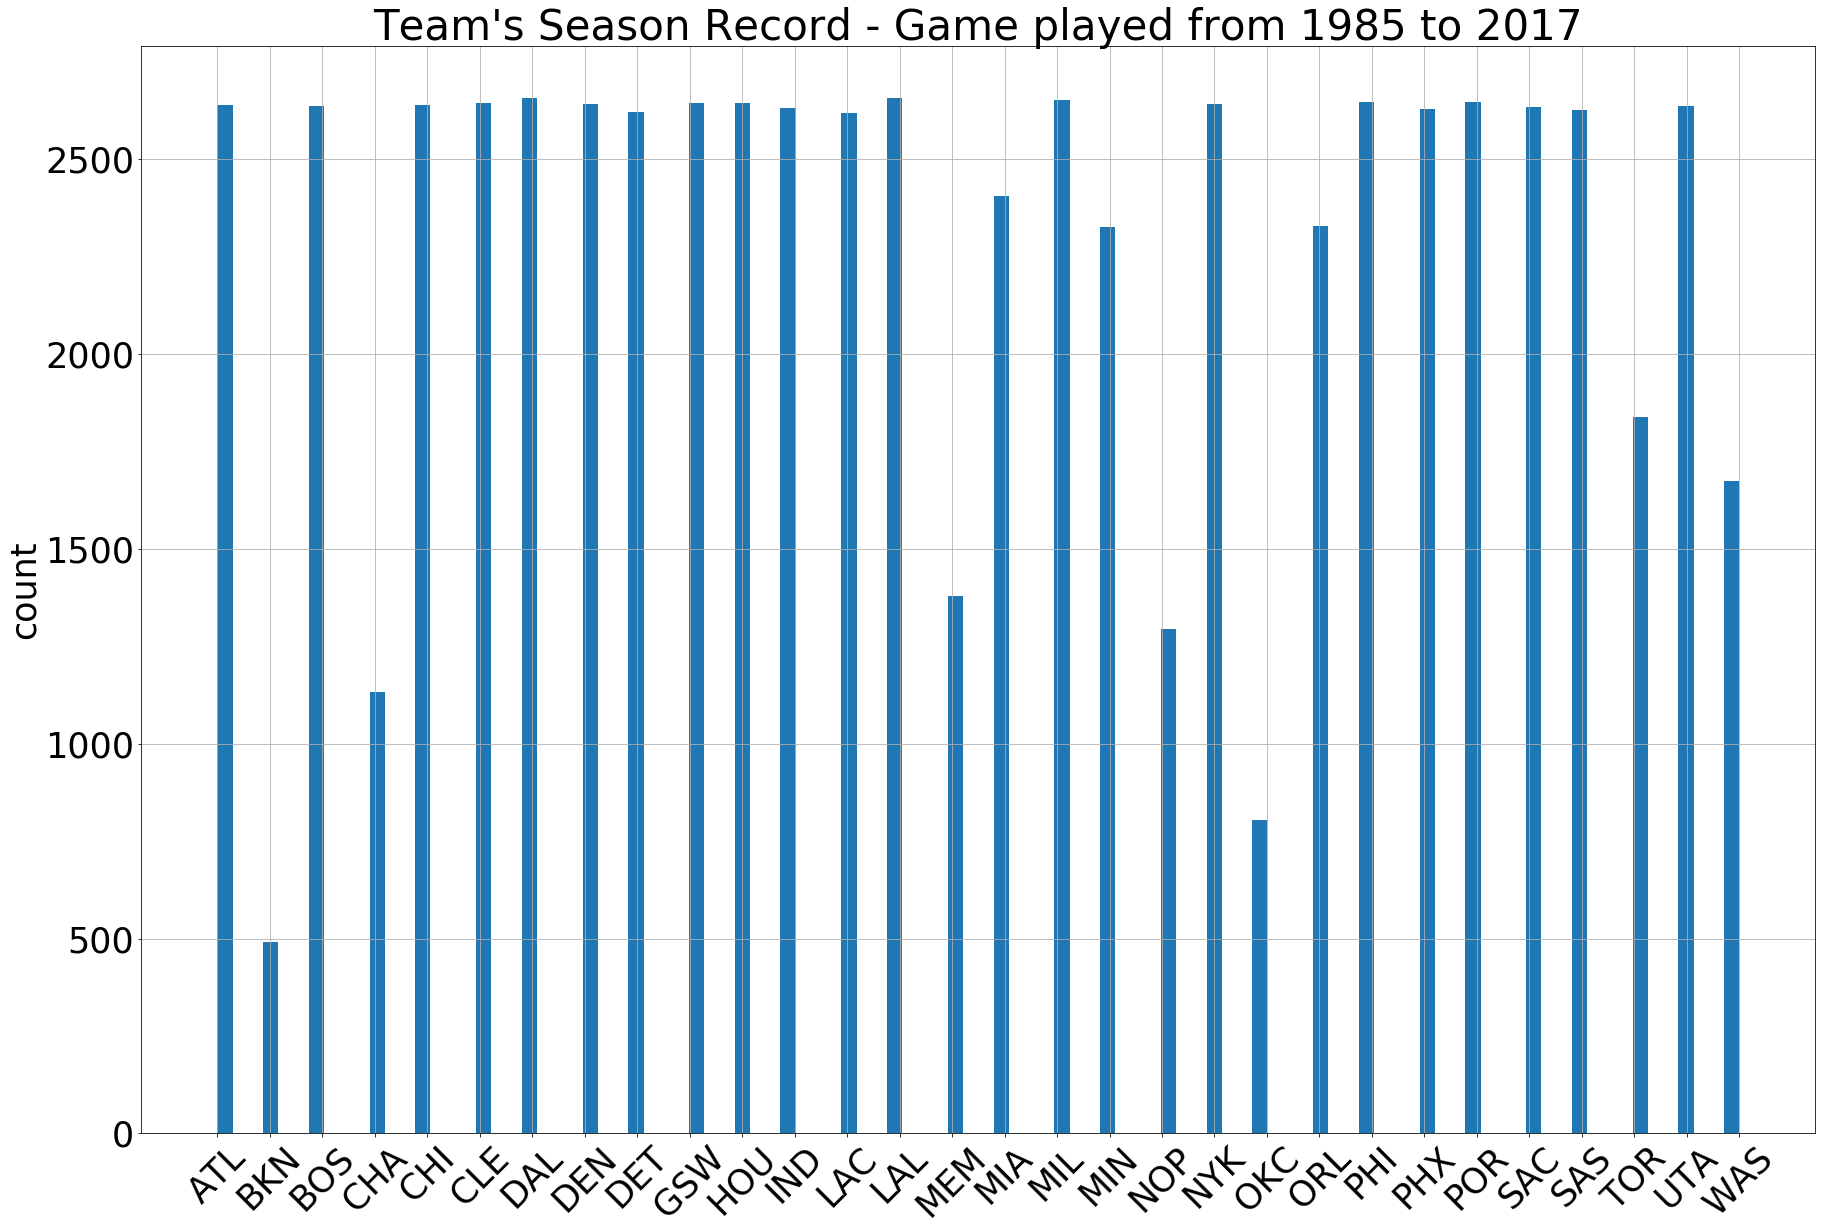

In [154]:
plt.figure(figsize=(30, 20))
plt.rcParams.update({'font.size': 35})

season['Team'].hist(bins = 100)
plt.xticks(rotation='45')
plt.title('Team\'s Season Record - Game played from 1985 to 2017')
plt.ylabel('count')

### Observe the playoff data (1985-2018)

In [155]:
playoff = pd.read_csv("team_playoff_all.csv")
#Remove NaN
playoff = CleanDataset(playoff)
playoff.describe()

,FG%,FGM,FGA,3P%,3PM,3PA,FT%,FTM,FTA,REB,OREB,DREB,AST,STL,BLK,TOV,PF,PTS
count,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000
mean,0.452040,36.110303,79.989406,0.338058,5.772538,16.614458,0.753068,20.060656,26.645617,41.495845,11.564603,29.931242,20.910677,7.268592,4.971541,13.291442,23.105733,98.053801
std,0.058941,5.744082,8.308693,0.142761,3.609437,8.228990,0.100740,6.742516,8.318801,6.522658,4.248010,5.227034,5.418792,2.815606,2.585062,3.816759,4.645576,13.317871
min,0.244000,17.000000,51.000000,0.000000,0.000000,1.000000,0.286000,2.000000,5.000000,18.000000,1.000000,12.000000,3.000000,0.000000,0.000000,3.000000,9.000000,54.000000
25%,0.412000,32.000000,74.000000,0.250000,3.000000,11.000000,0.690000,15.000000,21.000000,37.000000,9.000000,26.000000,17.000000,5.000000,3.000000,11.000000,20.000000,89.000000
50%,0.451000,36.000000,79.000000,0.333000,5.000000,16.000000,0.760000,20.000000,26.000000,41.000000,11.000000,30.000000,20.000000,7.000000,5.000000,13.000000,23.000000,97.000000
75%,0.492000,40.000000,85.000000,0.424000,8.000000,22.000000,0.821000,24.000000,32.000000,46.000000,14.000000,33.000000,24.000000,9.000000,7.000000,16.000000,26.000000,107.000000
max,0.670000,63.000000,130.000000,1.000000,25.000000,52.000000,1.000000,57.000000,64.000000,68.000000,28.000000,50.000000,46.000000,20.000000,19.000000,33.000000,41.000000,157.000000


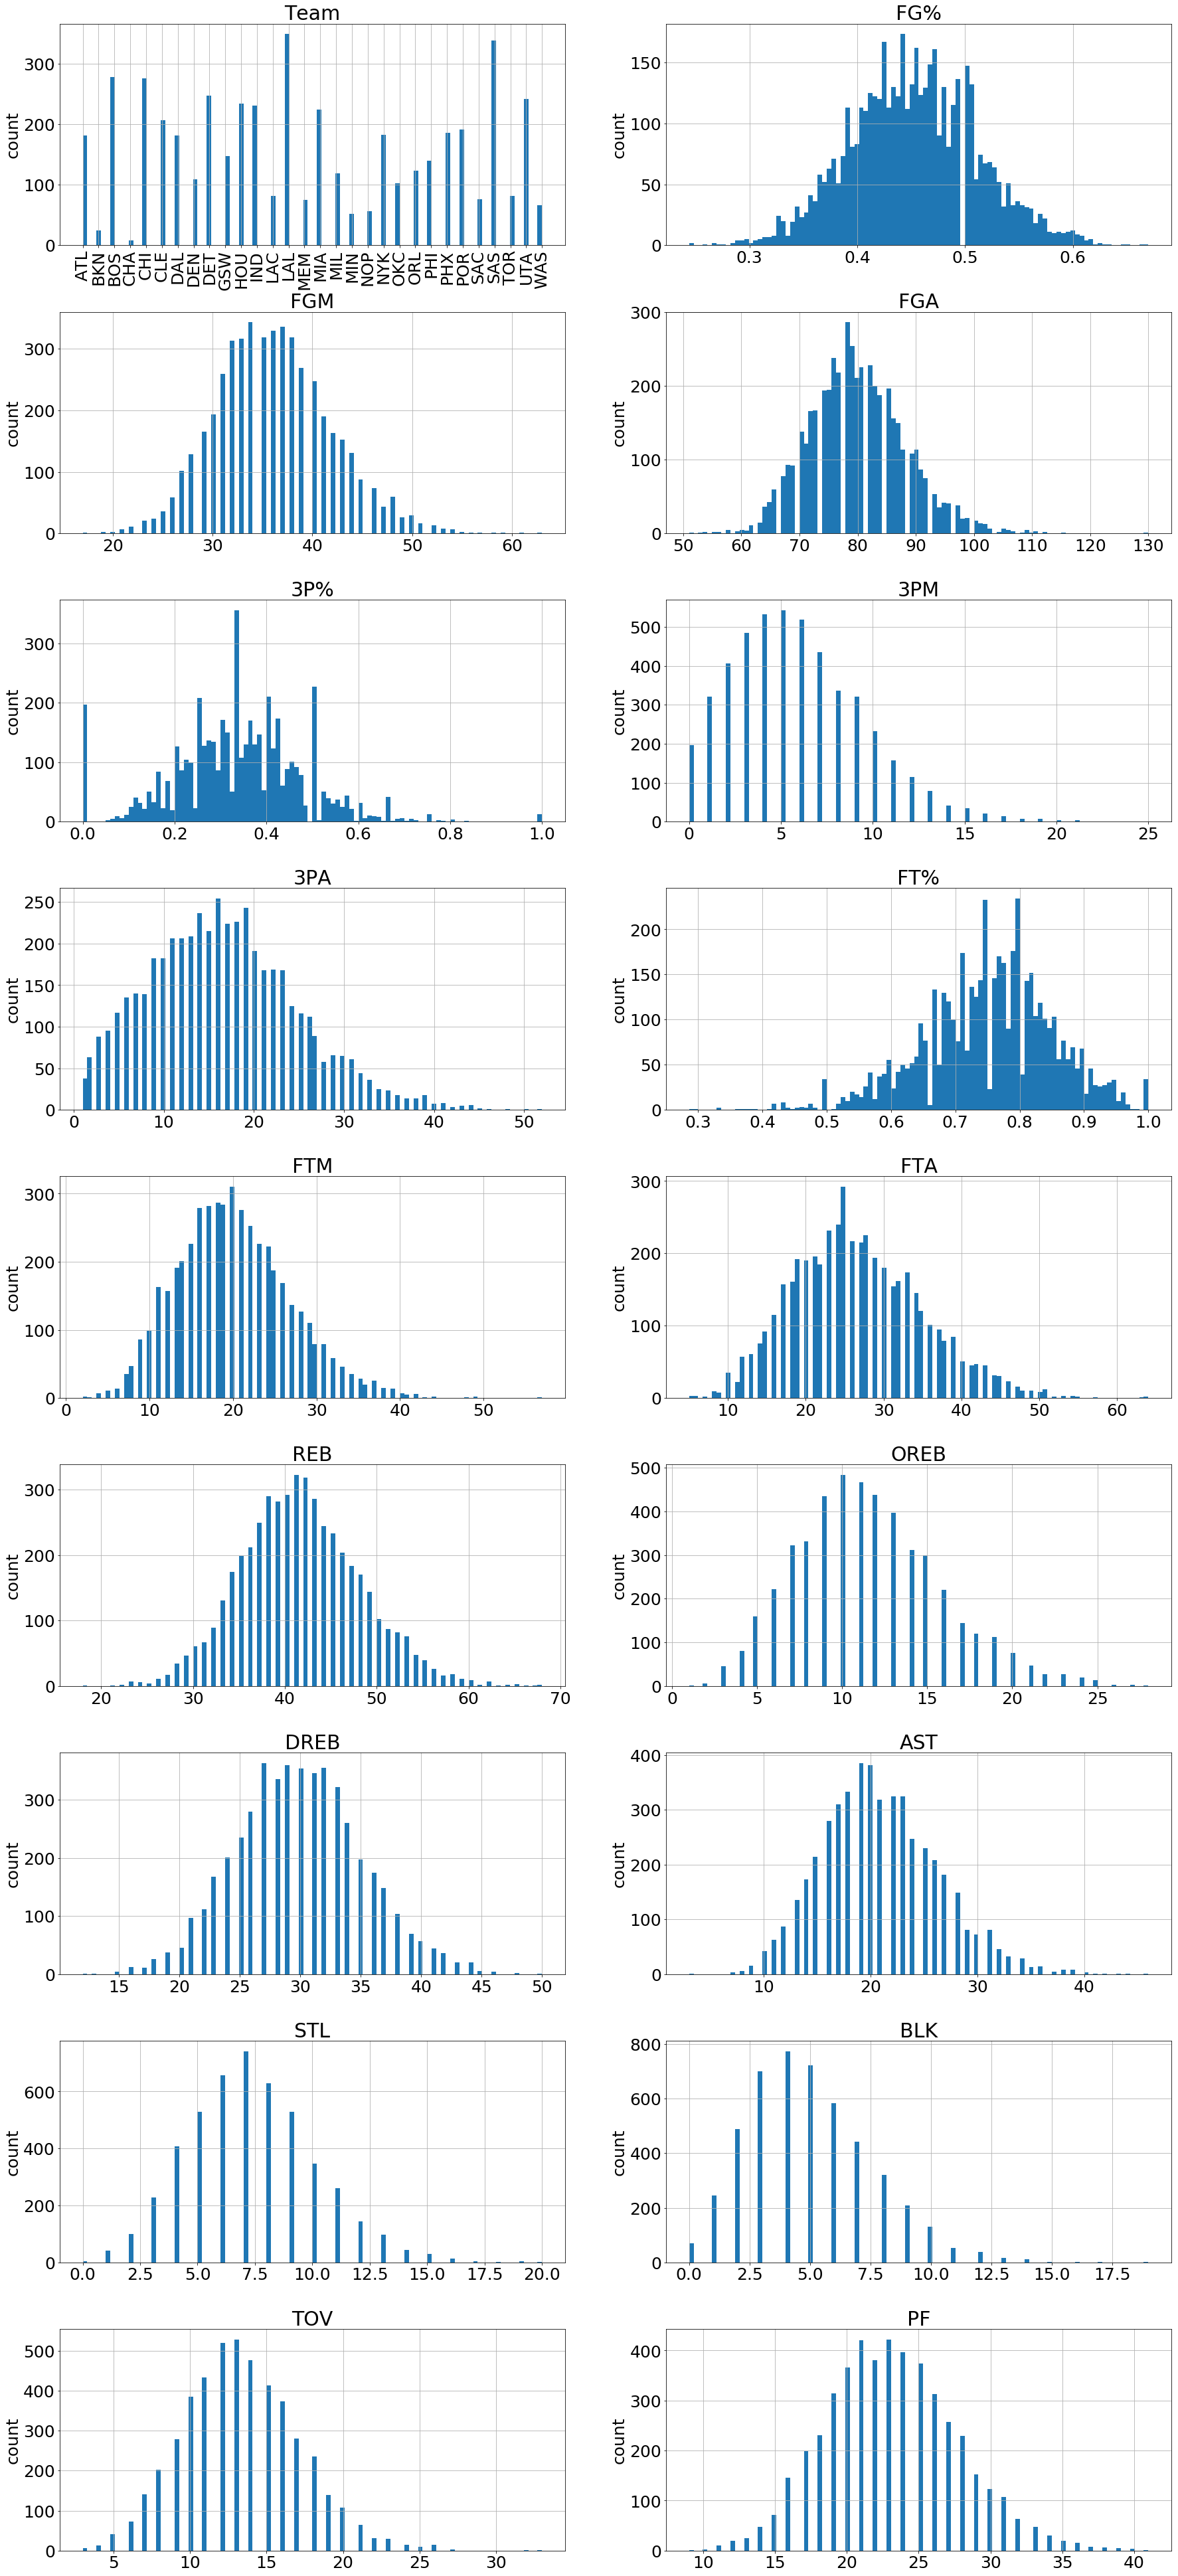

In [156]:
PrintStatistic(playoff)

Text(0,0.5,'count')

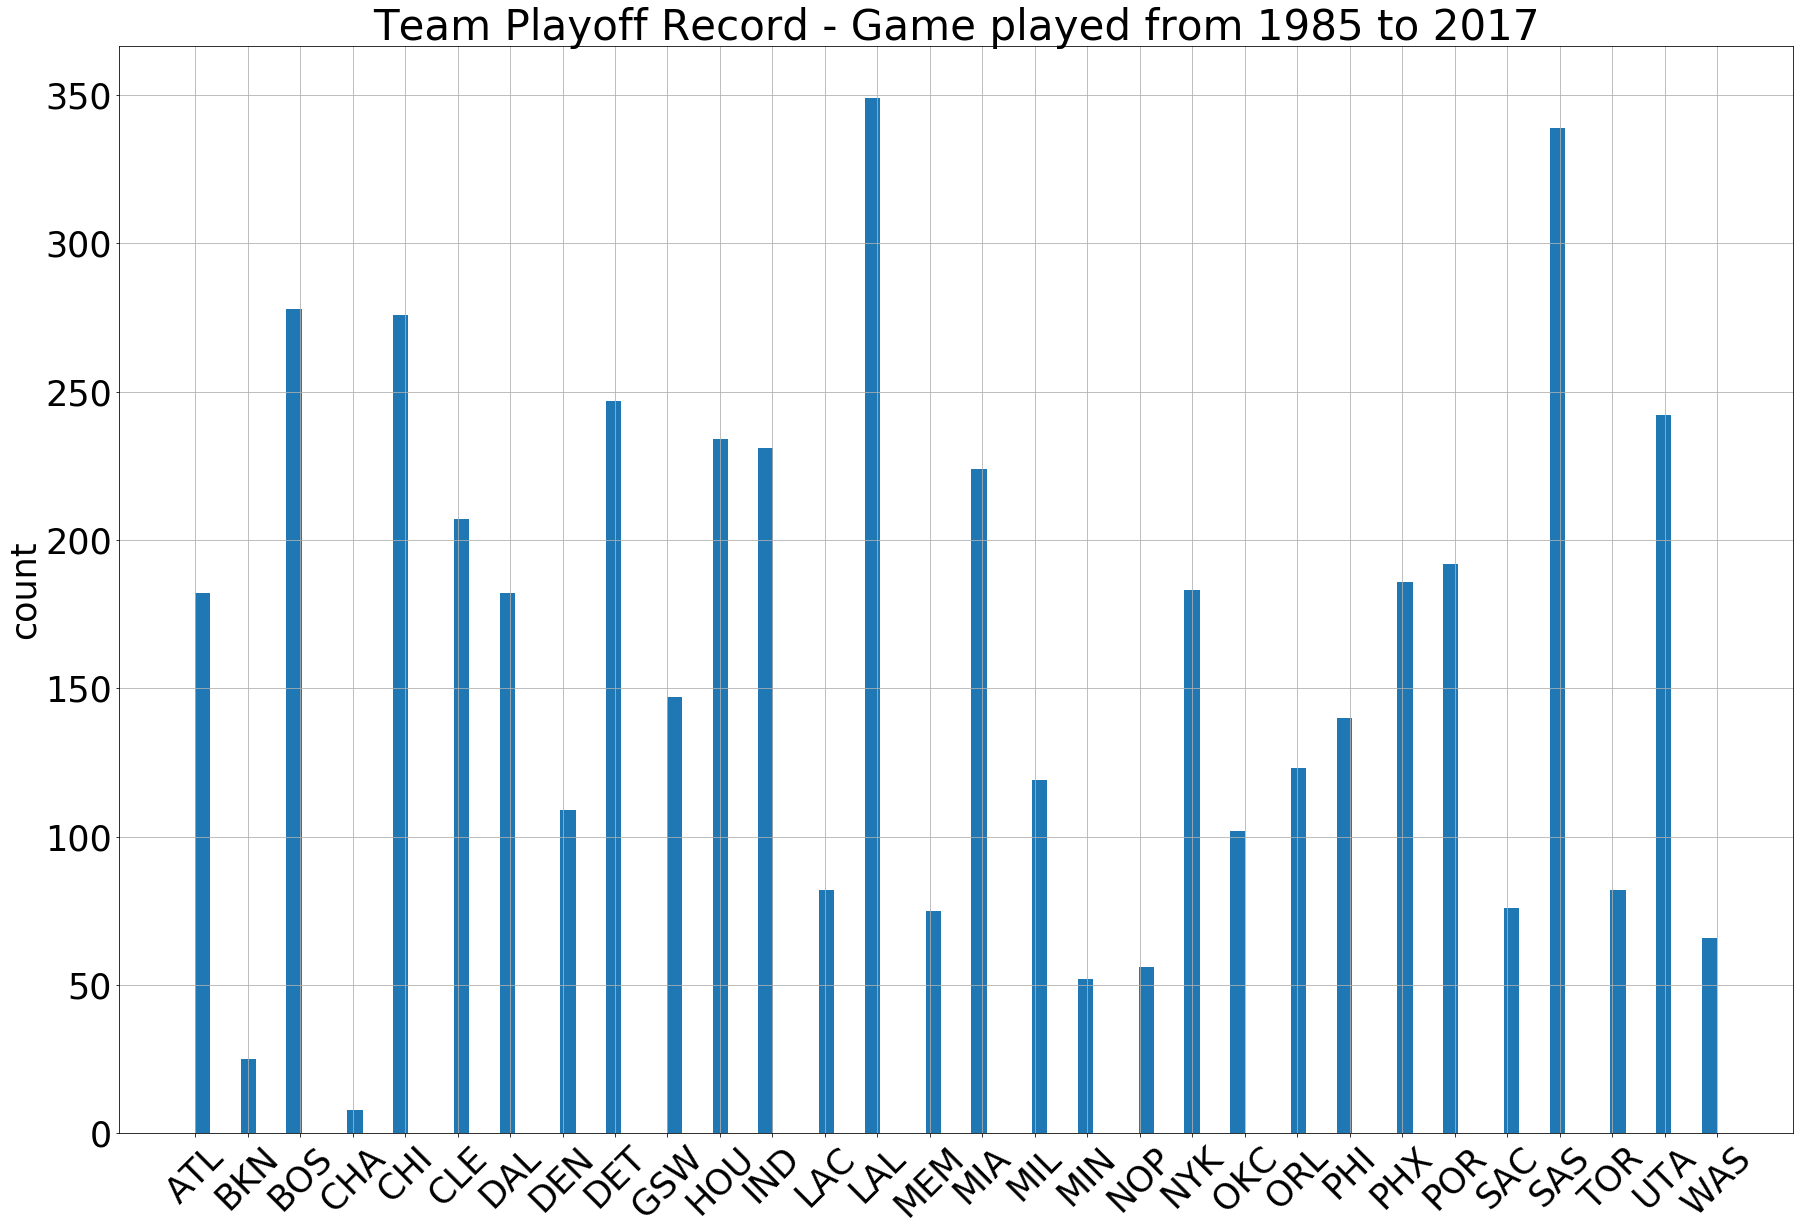

In [157]:
plt.figure(figsize=(30, 20))
plt.rcParams.update({'font.size': 35})

playoff['Team'].hist(bins = 100)
plt.xticks(rotation='45')
plt.title('Team Playoff Record - Game played from 1985 to 2017')
plt.ylabel('count')

### Comments : 
    - The distribution of all the attributes(e.g.,FG%, FGM, FGA, 3P%, 3PM,..., etc.) are near to Gaussion.
    - The attributes distribution between playseasion and playoff are similar.
    - Only the count of games that each team plays during 1985-2018 are different. 
    - For the Season, history of each team is not the same. For example, BKN is grouped in 2012, so the count is low.
    - For the Playoff, not all the teams can enter the playoff. Only 16 out of 30 teams enter the playoff per year.

## Data Preporcessing

    - 1. Merge season & playoff data
    - 2. Remove NaN
    - 3. Merge the attributes of two teams into one feature set.
    - 4. Binary Encoding of Win/Lose and Home/Away
    - 5. Pairing two teams in a single game by searching 'Date' and 'Opponent' labels
    - 6. Check game validity to see whether there is any inconsistent of the pairing game in 5. step.

In [14]:
# @param df: pandas.DataFrame
# @return pandas.DataFrame
# NaN cleaner (Numerical)
def cleanDataFrame(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].reset_index(drop=True)

# @param df: pandas.DataFrame
# @return pandas.DataFrame
# Drop objects which are NaN in Score's label (String)
def dropNanScore(df):
    index = []
    for idx, score in enumerate(df['Score']):
        if score[:3] == 'NAN' or score[:3] == 'NaN':
            index.append(idx)
    print("Number of objects dropped =", len(index))
    return df.drop(df.index[index]).reset_index(drop=True)

# @param df: pandas.DataFrame
# @return df: pandas.DataFrame
# Add opponent label to a game
def addOpponentCol(df):
    opponent = [None] * len(df['Score'])
    for idx, score in enumerate(df['Score']):
        opponent[idx] = score[:3]
    df['Opponent'] = opponent
    return df

# @param df: pandas.DataFrame
# @return df_team, df_oppo: pandas.DataFrame
# Pair two teams in a single game by searching 'Date' and 'Opponent' labels.
def pairGamePlayers(df):  
    startTime = time.time()
    invalid_idx = []
    duplicate = 0
    not_found = 0
    # Declare empty dataframe w/ columns from existing dataframe
    df_team = pd.DataFrame(columns = list(df)) # Team attributes
    df_oppo = pd.DataFrame(columns = list(df)) # Opponent attributes
    df_dupl = pd.DataFrame(columns = list(df)) # Duplicated dataframe
    for idx, date, team in zip(df.index.tolist(), df['Date'], df['Team']):
        df_oppo_searched = df.loc[lambda df: df.Date == date, :].loc[lambda df: df.Opponent == team, :]
        if len(df_oppo_searched.index.tolist()) > 1:
            duplicate += 1
            df_dupl = pd.concat([df_dupl, df_oppo_searched], ignore_index=True)
            df_oppo_searched = df_oppo_searched.iloc[0:1, :]
        if not df_oppo_searched.empty:
            df_team = pd.concat([df_team, df.iloc[idx:idx+1, :]], ignore_index=True)
            df_oppo = pd.concat([df_oppo, df_oppo_searched], ignore_index=True)
        else:
            invalid_idx.append(idx)
            not_found += 1
    
    print("Duplicate found =", duplicate)
    print("Opponent not found =", not_found)
    print("Team length = ", len(df_team.index.tolist()))
    print("Oppo length = ", len(df_oppo.index.tolist()))
    print("Execution time =", time.time() - startTime)
    return df_team, df_oppo, invalid_idx

# @param df_team, df_oppo: pandas.DataFrame
# @return df_team, df_oppo: pandas.DataFrame
# Check game validity after pairGamePlayers(df) which pairs two teams in a single game.
def checkGameValidity(df_team, df_oppo):
    startTime = time.time()
    err = 0
    invalid_idx = []
    print("Team length = ", len(df_team.index.tolist()))
    print("Oppo length = ", len(df_oppo.index.tolist()))
    for idx in df_team.index.tolist():
        if df_team.loc[idx]['Date'] != df_oppo.loc[idx]['Date'] or \
        df_team.loc[idx]['Opponent'] != df_oppo.loc[idx]['Team'] or \
        df_team.loc[idx]['W/L'] == df_oppo.loc[idx]['W/L'] or \
        df_team.loc[idx]['Home/Away'] == df_oppo.loc[idx]['Home/Away']:
            err += 1
            invalid_idx.append(idx)
    
    df_team = df_team.drop(df_team.index[invalid_idx]).reset_index(drop=True)
    df_oppo = df_oppo.drop(df_oppo.index[invalid_idx]).reset_index(drop=True)
    
    print("Number of invalid games =", err, "@", [x for x in invalid_idx])
    print("Execution time =", time.time() - startTime)
    return df_team, df_oppo, invalid_idx

In [27]:
startTime = time.time()
    
# Merge seasona and playoff
df_all = pd.concat([season, playoff], ignore_index=True)
    
# Remove NaN
df_all = cleanDataFrame(df_all)
df_all = dropNanScore(df_all)
    
    # Add opponent label
df_all = addOpponentCol(df_all)
    
# Binary encode W/L and Home/Away
df_all['W/L'] = df_all['W/L'].map({'W':1, 'L':0})
df_all['Home/Away'] = df_all['Home/Away'].map({'Home':1, 'Away':0})
    
# Pair teams and opponents
df_team, df_oppo, invalid_idx = pairGamePlayers(df_all)
    
# Check games' validity
df_team, df_oppo, invalid_idx = checkGameValidity(df_team, df_oppo)
    
# Rename column: Attributes_A and Attributes_B for team and opponent, respectively
df_team = df_team.rename(columns=lambda x: x + '_A')
df_oppo = df_oppo.rename(columns=lambda x: x + '_B')
    
# Concatenate by column
df_output = pd.concat([df_team, df_oppo], axis=1)
    
# Save .csv
df_output.to_csv('./nba_preprocessed.csv', encoding='utf-8', index=False)
    
print("Execution time =", time.time() - startTime)

Number of objects dropped = 5255
Duplicate found = 0
Opponent not found = 6399
Team length =  61618
Oppo length =  61618
Execution time = 3290.0638670921326
Team length =  61618
Oppo length =  61618
Number of invalid games = 252 @ [1931, 1968, 1976, 1981, 1995, 1998, 2006, 2037, 4119, 4166, 4194, 4227, 6230, 6294, 6301, 6341, 6400, 8457, 8501, 8529, 8585, 9576, 9594, 9671, 9678, 11759, 11765, 11844, 11858, 13912, 13964, 14008, 14010, 16117, 16121, 16147, 16174, 18100, 18240, 18290, 18341, 18357, 18870, 18892, 18950, 18960, 21015, 21020, 21094, 21128, 23200, 23235, 23288, 23292, 25365, 25384, 25449, 25481, 27287, 27314, 27332, 27384, 28736, 28758, 28774, 28778, 28802, 28809, 28850, 30757, 30768, 30790, 30806, 30835, 30840, 30889, 32781, 32798, 32816, 32819, 32863, 32865, 32896, 32928, 33103, 33138, 33147, 33171, 33212, 33224, 33232, 34973, 34982, 35009, 35042, 35046, 35064, 35094, 35109, 36971, 37045, 37055, 37108, 37114, 37120, 37121, 37152, 37172, 39079, 39143, 39145, 39157, 39166, 39

## Feature Engineering
    - 1. Extract attributes X, which represent the status of a team before a game : 
        -period stands for “How many previous games to be averaged”. We set 5 in this classification task.
        -featureSel stands for “What kind of attributes does the user want”. We drop the original attribute ['PTS'], and create one new attribute ['PTS_DIFF'].
    - 2. Extract labels Y – W/L is the label to be classified. Y=1 means the team with "*_A" will win. Y=0 means the team with "*_B" attributes will win.
    - 3. Extract the feature(X) & label(Y) from 2017-08-01 to 2018-04-13

In [15]:
# @param X: pandas.DataFrame
# @param featureSel: int
# @return X: pandas.DataFrame
def featureEng(X, featureSel=None):
    # Feature Engineering
    if not featureSel or featureSel == 0:
        return X
    if featureSel == 1:
        X['PTS_DIFF'] = X['PTS_A'] - X['PTS_B']
    elif featureSel == 2:
        attriToDrop = ['PTS_A', 'PTS_B']
        X = X.drop(columns=attriToDrop)
    elif featureSel == 3:
        X['PTS_DIFF'] = X['PTS_A'] - X['PTS_B']
        attriToDrop = ['PTS_A', 'PTS_B']
        X = X.drop(columns=attriToDrop)
    elif featureSel == 4:
        attriToDrop = [
            'FGM_A', 'FGA_A', '3PM_A', '3PA_A', 'FTM_A', 'FTA_A', 'OREB_A', 'DREB_A', 'PF_A', 
            'FGM_B', 'FGA_B', '3PM_B', '3PA_B', 'FTM_B', 'FTA_B', 'OREB_B', 'DREB_B', 'PF_B'
        ]
        X['PTS_DIFF'] = X['PTS_A'] - X['PTS_B']
        X['STL+BLK_A'] = X['STL_A'] + X['BLK_A']
        X['STL+BLK_B'] = X['STL_B'] + X['BLK_B']
        attriToDrop += ['PTS_A', 'PTS_B', 'STL_A', 'STL_B', 'BLK_A', 'BLK_B']
        X = X.drop(columns=attriToDrop)
    return X

In [16]:
# @param dfFile: pandas.DataFrame ('nba_preprocessed.csv')
# @param dateStart, dateEnd: str in the format of 'YYYY-MM-DD'
# @param period: int
# @param featureSel: int
# @return X, Y: pandas.DataFrame
# featureExtraction() outputs X, Y for model training.
def featureExtraction(dfFile, dateStart='1000-01-01', dateEnd='2999-12-31', period=5, featureSel=None):
    df = pd.read_csv(dfFile)
    
    # Date selection
    df = df.loc[(df.Date_A >= dateStart) & (df.Date_A <= dateEnd), :].reset_index(drop=True)
    
    # Get label Y
    Y = df[['W/L_A']]
    Y = Y.rename(columns={'W/L_A': 'Label'})
    
    # Get averaged attributes X
    for idx, row in df.iterrows():
        df_sel = df.loc[df.Date_A <= row['Date_A'], :].reset_index(drop=True)
        
        # Process of Team_A
        gamePlayed_A = df_sel.loc[df_sel.Team_A == row['Team_A'], :]
        if len(gamePlayed_A) == 1:
            X_A = gamePlayed_A.loc[(gamePlayed_A.Team_A == row['Team_A']), :].sort_values(by=['Date_A'], ascending=False).iloc[0:1, 0:24].reset_index(drop=True)
        elif len(gamePlayed_A) < period:
            X_A = gamePlayed_A.loc[(gamePlayed_A.Team_A == row['Team_A']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:len(gamePlayed_A), 0:24].reset_index(drop=True)
        else:
            X_A = gamePlayed_A.loc[(gamePlayed_A.Team_A == row['Team_A']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:period+1, 0:24].reset_index(drop=True)
        
        # Process of Team_B
        gamePlayed_B = df_sel.loc[df_sel.Team_A == row['Team_B'], :]
        if len(gamePlayed_B) == 1:
            X_B = gamePlayed_B.loc[(gamePlayed_B.Team_A == row['Team_B']), :].sort_values(by=['Date_A'], ascending=False).iloc[0:1, 0:24].reset_index(drop=True)
        elif len(gamePlayed_B) < period:
            X_B = gamePlayed_B.loc[(gamePlayed_B.Team_A == row['Team_B']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:len(gamePlayed_B), 0:24].reset_index(drop=True)
        else:
            X_B = gamePlayed_B.loc[(gamePlayed_B.Team_A == row['Team_B']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:period+1, 0:24].reset_index(drop=True)
        
        # Drop unnecessary attributes
        colToDrop = ['Home/Away_A'] + ['Team_A', 'Date_A', 'W/L_A', 'Score_A', 'Opponent_A']
        X_A = X_A.drop(columns=colToDrop)
        X_B = X_B.drop(columns=colToDrop)
        
        # Rename X_B's columns
        X_B = X_B.rename(columns=lambda x: x[0:-2] + '_B')
        
        # Get X_single = [Home/Away_A + X_A + X_B]
        X_single = pd.DataFrame(data=pd.concat([X_A.mean(), X_B.mean()])).transpose()
        X_single = pd.concat([pd.DataFrame(data={'Home/Away_A': [row['Home/Away_A']]}), X_single], axis=1)
        
        # Concatenation dataFrames by row
        if idx == 0:
            X = X_single
        else:
            X = pd.concat([X, X_single], ignore_index=True)
        
    # Feature Engineering
    X = featureEng(X, featureSel)
        
    return X, Y

In [139]:
# Feature Extraction
dfFile = './nba_preprocessed.csv'
dateStart = '2017-08-01'
dateEnd = '2018-04-13'
period = 5
featureSel = 3
X, Y = featureExtraction(dfFile, dateStart, dateEnd, period, featureSel)
X.head()

,Home/Away_A,FG%_A,FGM_A,FGA_A,3P%_A,3PM_A,3PA_A,FT%_A,FTM_A,FTA_A,...,FTA_B,REB_B,OREB_B,DREB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B,PTS_DIFF
0,0,0.468000,36.000000,77.000000,0.481000,13.000000,27.000000,0.917000,11.000000,12.000000,...,16.000000,36.000000,6.000000,30.000000,28.000000,9.0,5.0,15.000000,18.0,-10.00
1,1,0.468000,36.000000,77.000000,0.481000,13.000000,27.000000,0.917000,11.000000,12.000000,...,11.500000,49.500000,12.500000,37.000000,19.500000,6.5,3.5,15.500000,19.0,-0.50
2,1,0.451500,36.500000,81.000000,0.407000,11.500000,28.500000,0.758500,11.500000,16.000000,...,36.500000,44.500000,11.500000,33.000000,23.000000,10.0,8.5,12.500000,19.0,-21.50
3,0,0.463667,37.333333,80.666667,0.387333,10.333333,26.666667,0.766667,13.666667,18.333333,...,31.666667,50.666667,8.333333,42.333333,16.666667,4.0,4.0,17.333333,18.0,1.00
4,0,0.443750,37.500000,85.250000,0.355000,9.750000,27.750000,0.725000,12.500000,17.500000,...,19.200000,43.400000,9.800000,33.600000,19.200000,9.4,3.6,14.400000,22.4,-0.95


In [140]:
Y.head()

,Label
0,0
1,1
2,0
3,0
4,1


### Data Visualization
    - To see the distributation of the feature points.
    - Use PCA to reduce the dimensionality from 36 to 2 for visulaization.

In [141]:
from sklearn.preprocessing import StandardScaler
features = list(X.columns)
X_val = X.values

# Feature standardization
X_val = StandardScaler().fit_transform(X_val)
X_val.shape

(2460, 36)

In [142]:
X.head()

,Home/Away_A,FG%_A,FGM_A,FGA_A,3P%_A,3PM_A,3PA_A,FT%_A,FTM_A,FTA_A,...,FTA_B,REB_B,OREB_B,DREB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B,PTS_DIFF
0,0,0.468000,36.000000,77.000000,0.481000,13.000000,27.000000,0.917000,11.000000,12.000000,...,16.000000,36.000000,6.000000,30.000000,28.000000,9.0,5.0,15.000000,18.0,-10.00
1,1,0.468000,36.000000,77.000000,0.481000,13.000000,27.000000,0.917000,11.000000,12.000000,...,11.500000,49.500000,12.500000,37.000000,19.500000,6.5,3.5,15.500000,19.0,-0.50
2,1,0.451500,36.500000,81.000000,0.407000,11.500000,28.500000,0.758500,11.500000,16.000000,...,36.500000,44.500000,11.500000,33.000000,23.000000,10.0,8.5,12.500000,19.0,-21.50
3,0,0.463667,37.333333,80.666667,0.387333,10.333333,26.666667,0.766667,13.666667,18.333333,...,31.666667,50.666667,8.333333,42.333333,16.666667,4.0,4.0,17.333333,18.0,1.00
4,0,0.443750,37.500000,85.250000,0.355000,9.750000,27.750000,0.725000,12.500000,17.500000,...,19.200000,43.400000,9.800000,33.600000,19.200000,9.4,3.6,14.400000,22.4,-0.95


In [143]:
from sklearn.decomposition import PCA
num_comp = 36
pca = PCA(n_components=num_comp)
X_val_pca = pca.fit_transform(X_val)
# X_PCA = pd.DataFrame(data = X_val_pca, columns = ['PC1', 'PC2'])
new_columns = ["PCA_"+str(x) for x in range(1, num_comp+1, 1)]
X_PCA = pd.DataFrame(data = X_val_pca, columns = new_columns)
X_PCA
print(pca.explained_variance_ratio_)
print(f'Explained Variance Ratio: {sum(pca.explained_variance_ratio_)}')

[1.04693411e-01 8.83853150e-02 7.80515283e-02 7.28446949e-02
 6.05347439e-02 5.79669648e-02 5.44128717e-02 4.98932471e-02
 4.10209841e-02 3.96484347e-02 3.68448945e-02 3.29965808e-02
 2.84312310e-02 2.79243145e-02 2.63151717e-02 2.38313780e-02
 2.34895541e-02 2.28179884e-02 2.24802702e-02 1.97671289e-02
 1.96058901e-02 1.64298665e-02 1.63486790e-02 9.60288324e-03
 9.42182830e-03 8.00416653e-03 7.34374911e-03 2.42655404e-04
 2.32637362e-04 1.58504572e-04 1.44372177e-04 6.11460203e-05
 5.29141442e-05 2.06471347e-32 1.47150730e-32 9.94104174e-33]
Explained Variance Ratio: 1.0000000000000002


In [144]:
from sklearn.decomposition import PCA
num_comp = 2
pca = PCA(n_components=num_comp)
X_val_pca = pca.fit_transform(X_val)
# X_PCA = pd.DataFrame(data = X_val_pca, columns = ['PC1', 'PC2'])
new_columns = ["PCA_"+str(x) for x in range(1, num_comp+1, 1)]
X_PCA = pd.DataFrame(data = X_val_pca, columns = new_columns)
X_PCA
print(pca.explained_variance_ratio_)
print(f'Explained Variance Ratio: {sum(pca.explained_variance_ratio_)}')

[0.10469341 0.08838531]
Explained Variance Ratio: 0.1930787246051638


Number of label 0 = 1230
Number of label 1 = 1230


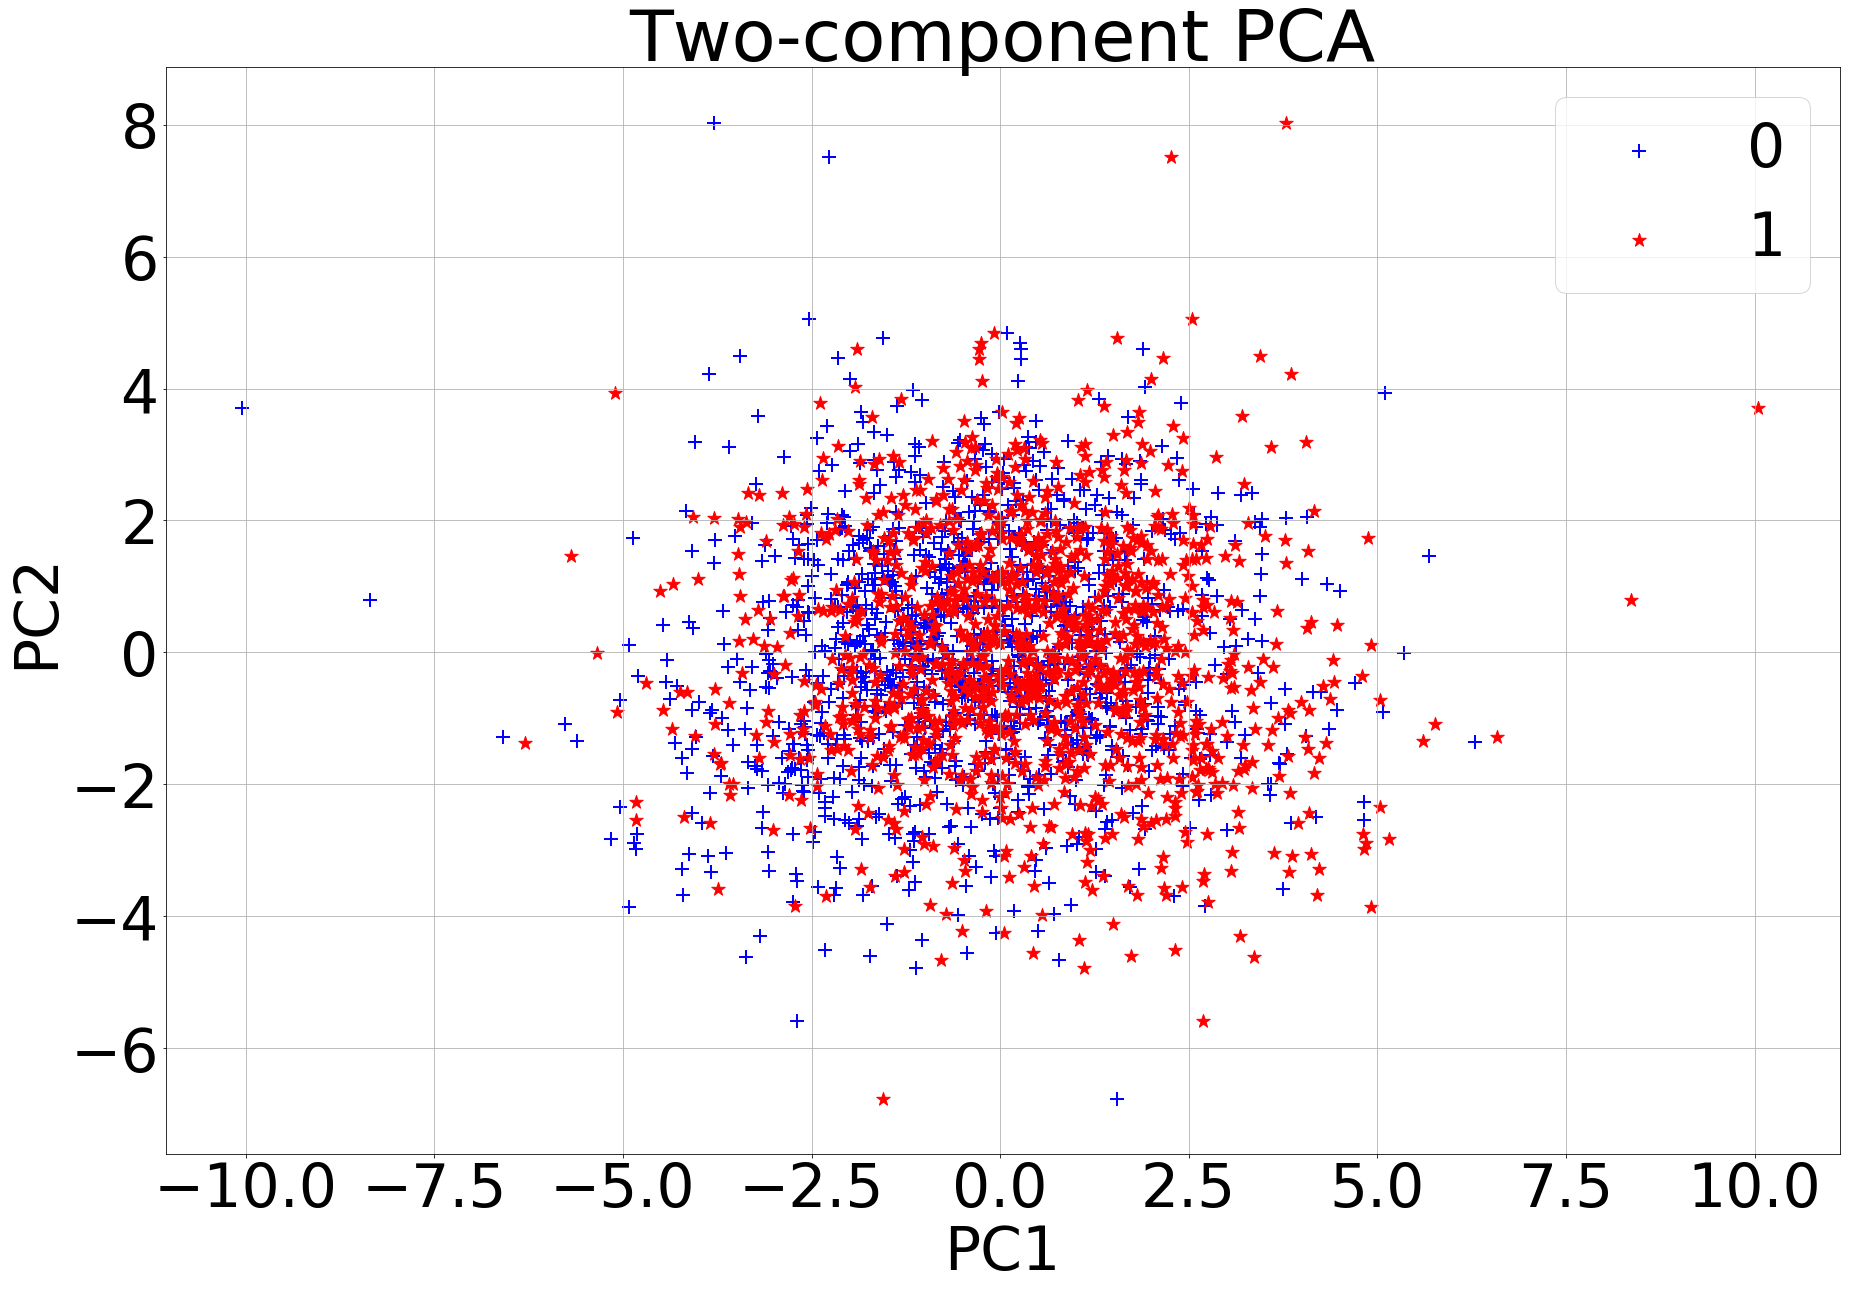

In [145]:
import time
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 20))
matplotlib.rcParams.update({'font.size': 60})
labels = [0, 1]
colors = ['b', 'r']
markers = ['+', '*']
for label, c, m in zip(labels, colors, markers):
    indicesToKeep = Y['Label'] == label
    print('Number of label', label, '=', list(indicesToKeep).count(label))
    plt.scatter(X_PCA.loc[indicesToKeep, 'PCA_1'], X_PCA.loc[indicesToKeep, 'PCA_2'], color=c, marker=m, s=200)
plt.grid(True)
plt.legend(labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Two-component PCA')
plt.show()

### Comments : 
    - The feature points are balence.
    - It does make sense, since every game in NBA will produce two training data, that is, one with feature = {feature_A, feature_B}, and label=1, and the other is feature = {feature_B, feature_A}, and label = 0. 

## Model Training & Testing

### Classification
    - 1. Generate feature set for testing data.
    - 2. The feature set is generated using "period" and "feature_sel" as in "Feature Engineering" above.
        -period stands for “How many previous games to be averaged”. We set 5 in this classification task.
        -featureSel stands for “What kind of attributes does the user want”. We drop the original attribute ['PTS'], and create one new attribute ['PTS_DIFF'].
    - 3. Extract labels Y – W/L is the ground truth. Y=1 means the team with "*_A" will win. Y=0 means the team with "*_B" attributes will win.

In [24]:
# @param dfFile: pandas.DataFrame (from 'nba_preprocessed.csv')
# @param date: str in the format of 'YYYY-MM-DD'
# @param period: int (Number of previous games to be considered)
# @param Team_A, Team_B: str
# @param homeAway: int (None for played game prediction)
# @param featureSel: int
# @return X: pandas.DataFrame
def attriGen(df, date, period, Team_A, Team_B, homeAway=None, featureSel=None):
    # True Home/Away at the game day
    if homeAway is None:
        df_gameDay = df.loc[(df.Date_A == date) & (df.Team_A == Team_A) & (df.Team_B == Team_B), :].reset_index(drop=True)
        homeAway = int(df_gameDay['Home/Away_A'])
    
    # Date selections
    df = df.loc[df.Date_A < date, :].reset_index(drop=True)
    X_A = df.loc[(df.Team_A == Team_A), :].sort_values(by=['Date_A'], ascending=False).iloc[0:period, 0:24].reset_index(drop=True)
    X_B = df.loc[(df.Team_A == Team_B), :].sort_values(by=['Date_A'], ascending=False).iloc[0:period, 0:24].reset_index(drop=True)
    
    # Drop unnecessary attributes
    colToDrop = ['Home/Away_A'] + ['Team_A', 'Date_A', 'W/L_A', 'Score_A', 'Opponent_A']
    X_A = X_A.drop(columns=colToDrop)
    X_B = X_B.drop(columns=colToDrop)
    
    # Rename X_away's columns
    X_B = X_B.rename(columns=lambda x: x[0:-2] + '_B')
    
    # Get X = [Home/Away_A + X_A + X_B]
    X = pd.DataFrame(data=pd.concat([X_A.mean(), X_B.mean()])).transpose()
    X = pd.concat([pd.DataFrame(data={'Home/Away_A': [homeAway]}), X], axis=1)
    
    # Feature Engineering
    X = featureEng(X, featureSel)
    
    return X

In [25]:
# @param dfFile: pandas.DataFrame (from 'nba_preprocessed.csv')
# @param date: str in the format of 'YYYY-MM-DD'
# @param Team_A, Team_B: str
# @param featureSel: int
# @return X_groundTruth, Y_groundTruth: pandas.DataFrame
def groundTruthGen(df, date, Team_A, Team_B, featureSel=None):
    # Date selections
    df = df.loc[(df.Date_A == date) & (df.Team_A == Team_A) & (df.Team_B == Team_B), :].reset_index(drop=True)

    # Get label Y
    Y_groundTruth = df[['W/L_A']]
    Y_groundTruth = Y_groundTruth.rename(columns={'W/L_A': 'Label'})
    
    # Drop unnecessary attributes
    colToDrop = [
        'Team_A', 'Date_A', 'W/L_A', 'Score_A', 'Opponent_A', 
        'Team_B', 'Date_B', 'W/L_B', 'Home/Away_B', 'Score_B', 'Opponent_B'
    ]
    X_groundTruth = df.drop(columns=colToDrop)
    
    # Feature Engineering
    X_groundTruth = featureEng(X_groundTruth, featureSel)
    
    return X_groundTruth, Y_groundTruth

In [26]:
# @param dfFile: pandas.DataFrame ('nba_preprocessed.csv')
# @param dateStart, dateEnd: str in the format of 'YYYY-MM-DD'
# @param period: int
# @param Team_A, Team_B: str (If both are None, predict all games within the date range)
# @param featureSel: int
# @return X, Y: pandas.DataFrame
# gameAttriGen() outputs X_attri, Y_truth for game prediction.
def gameAttriGen(dfFile, dateStart, dateEnd, period=5, Team_A=None, Team_B=None, featureSel=None):
    df = pd.read_csv(dfFile)
    
    # Date selections
    df_sel = df.loc[(df.Date_A >= dateStart) & (df.Date_A <= dateEnd), :].reset_index(drop=True)
    
    # Generate df_sel which includes [date, Team_A, Team_B] columns
    if Team_A and Team_B:
        df_sel = df_sel.loc[(df_sel.Team_A == Team_A) & (df_sel.Opponent_A == Team_B), :].reset_index(drop=True)[['Date_A', 'Team_A', 'Opponent_A']]
    elif Team_A and not Team_B:
        df_sel = df_sel.loc[df_sel.Team_A == Team_A, :].reset_index(drop=True)[['Date_A', 'Team_A', 'Opponent_A']]
    elif not Team_A and Team_B:
        df_sel = df_sel.loc[df_sel.Opponent_A == Team_B, :].reset_index(drop=True)[['Date_A', 'Team_A', 'Opponent_A']]
    elif not Team_A and not Team_B:
        df_sel = df_sel[['Date_A', 'Team_A', 'Opponent_A']]
        # Delete duplicates: (Team_A vs Team_B) is the same as (Team_B vs Team_A). Remove one to avoid double count.
        df_new = pd.DataFrame(columns=['Date_A', 'Team_A', 'Opponent_A'])
        LUT = {}
        for date, x, y in zip(df_sel['Date_A'], df_sel['Team_A'], df_sel['Opponent_A']):
            if (date + x + y) in LUT:
                df_new = pd.concat([df_new, pd.DataFrame(columns=['Date_A', 'Team_A', 'Opponent_A'], data=[[date, x, y]])], ignore_index=True)
            else:
                LUT[date + x + y] = 1
                LUT[date + y + x] = 1
        df_sel = df_new
    
    # W/L prediction
    X_attri = Y_truth = None
    for date, Team_A, Team_B in zip(df_sel['Date_A'], df_sel['Team_A'], df_sel['Opponent_A']):
        X_toBePredicted = attriGen(df, date, period, Team_A, Team_B, None, featureSel)
        X_groundTruth, Y_groundTruth = groundTruthGen(df, date, Team_A, Team_B, featureSel)
        if X_attri is None and Y_truth is None:
            X_attri = X_toBePredicted
            Y_truth = Y_groundTruth
        else:
            X_attri = pd.concat([X_attri, X_toBePredicted], ignore_index=True)
            Y_truth = pd.concat([Y_truth, Y_groundTruth], ignore_index=True)
        
    return X_attri, Y_truth

In [27]:
from sklearn.metrics import accuracy_score
# @param dfFile: pandas.DataFrame ('nba_preprocessed.csv')
# @param modelsLUT: dict in the format of {'modelName': model}
# @param dateStart, dateEnd: str in the format of 'YYYY-MM-DD'
# @param period: int (Number of previous games to be considered)
# @param Team_A, Team_B: str (If both are None, predict all games within the date range)
# @param featureSel: int
# @return None
# gamePrediction() prints the predicted game W/L results.
def gamePrediction(dfFile, modelsLUT, dateStart, dateEnd, period=5, Team_A=None, Team_B=None, featureSel=None, is_print_result=0):
    X_attri, Y_truth = gameAttriGen(dfFile, dateStart, dateEnd, period, Team_A, Team_B, featureSel)
    
    resultLUT, accuLUT = {}, {}
    for model in modelsLUT:
        resultLUT[model] = modelsLUT[model].predict(X_attri)
        #accuLUT[model] = accuracy_score(Y_truth, modelsLUT[model].predict(X_attri))
        accuLUT[model] = accuracy_score(Y_truth, resultLUT[model])
    
    if(is_print_result):
        print('---------- Prediction Accuracy ----------')
        print('featureSel =', featureSel)
        for x in accuLUT:
            print(x, '=', accuLUT[x]*100, '%')
        print('------------------------------------')
    return accuLUT

In [43]:
# Model Training
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

logiRegr = LogisticRegression()
logiRegr.fit(X, Y.values.ravel())

supVecMachine = SVC(kernel='linear', probability=True)
supVecMachine.fit(X, Y.values.ravel())

xgbc = xgb.XGBClassifier()
xgbc.fit(X, Y.values.ravel())

naiveBayes = GaussianNB()
naiveBayes.fit(X, Y.values.ravel())

randomForest = RandomForestClassifier()
randomForest.fit(X, Y.values.ravel())

gbdt = GradientBoostingClassifier()
gbdt.fit(X,Y.values.ravel())

lgbm = LGBMClassifier()
lgbm.fit(X, Y.values.ravel())

adaBoost = AdaBoostClassifier()
adaBoost.fit(X, Y.values.ravel())

# Prediction
dateStart = '2018-04-14'
dateEnd = '2018-06-01'
Team_A = None
Team_B = None
modelsLUT = {
    'logiRegr': logiRegr,
    'supVecMachine': supVecMachine,
    'xgbc': xgbc,
    'naiveBayes': naiveBayes,
    'randomForest': randomForest,
    'gbdt': gbdt,
    'lgbm': lgbm, 
    'adaBoost': adaBoost
}

# W/L prediction
gamePrediction(dfFile, modelsLUT, dateStart, dateEnd, period, Team_A, Team_B, featureSel, 1)

---------- Prediction Accuracy ----------
featureSel = 3
logiRegr = 69.62025316455697 %
supVecMachine = 70.88607594936708 %
xgbc = 74.68354430379746 %
naiveBayes = 60.75949367088608 %
randomForest = 60.75949367088608 %
gbdt = 72.15189873417721 %
lgbm = 69.62025316455697 %
adaBoost = 68.35443037974683 %
------------------------------------


{'adaBoost': 0.6835443037974683,
 'gbdt': 0.7215189873417721,
 'lgbm': 0.6962025316455697,
 'logiRegr': 0.6962025316455697,
 'naiveBayes': 0.6075949367088608,
 'randomForest': 0.6075949367088608,
 'supVecMachine': 0.7088607594936709,
 'xgbc': 0.7468354430379747}

## Parameter Search

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score

In [45]:
def ParameterSearch(X=None, Y=None, dateStart='2018-04-14', dateEnd='2018-06-01', Team_A=None, Team_B=None, 
                    param_name=None, param_list=None, model=None, title=None, **other_setting):
    total_acc = []
    max_acc = -1
    max_param_val = -1
    total_len = len(param_list)
    count_prog = 0
    for val in param_list:
        other_setting[param_name] = val
        model.set_params(**other_setting)
        model.fit(X, Y.values.ravel())
    
        modelsLUT = {
            'model': model
        }
        ret_acc = gamePrediction(dfFile, modelsLUT, dateStart, dateEnd, period, Team_A, Team_B, featureSel, 0)
    
        for model_name in modelsLUT:
            total_acc.append(ret_acc[model_name])
            if(total_acc[-1] > max_acc):
                max_acc = total_acc[-1]
                max_param_val = val
        count_prog += 1
        print('Progress = {x}%'.format(x = count_prog/total_len*100))
    
    print(f'max_acc = {max_acc}, with {param_name} = {max_param_val}')
    plt.plot(param_list, total_acc)
    plt.xlabel(f' {title} ')
    plt.ylabel(' Accuracy ')
    plt.show()  

### LogisticRegression

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.6962025316455697, with C = 0.1


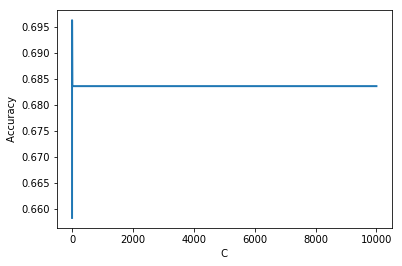

In [46]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=LogisticRegression()
                , title = 'C', max_iter=300)

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.6962025316455697, with max_iter = 10


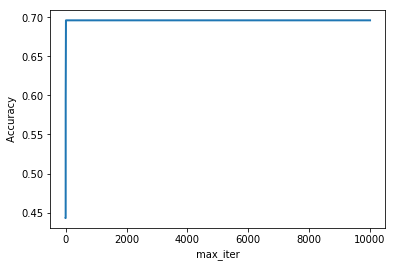

In [47]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_iter'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=LogisticRegression()
                , title = 'max_iter', C=0.1)

Progress = 10.0%
Progress = 20.0%
Progress = 30.0%
Progress = 40.0%
Progress = 50.0%
Progress = 60.0%
Progress = 70.0%
Progress = 80.0%
Progress = 90.0%
Progress = 100.0%
max_acc = 0.6962025316455697, with max_iter = 6


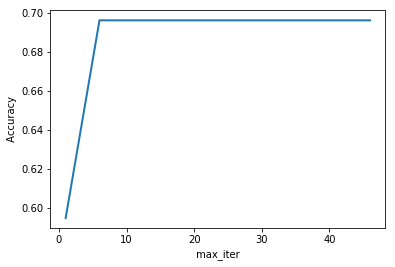

In [49]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_iter'
                , param_list=range(1, 50, 5), model=LogisticRegression()
                , title = 'max_iter', C=0.1)

### Result : C = 0.1, max_iter = 6

### SVM

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.759493670886076, with C = 10000


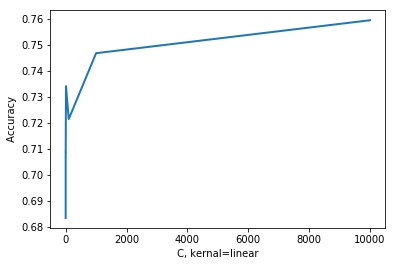

In [48]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=SVC()
                , title='C, kernal=linear', kernel='linear', probability=True)

Progress = 11.11111111111111%
Progress = 22.22222222222222%
Progress = 33.33333333333333%
Progress = 44.44444444444444%
Progress = 55.55555555555556%
Progress = 66.66666666666666%
Progress = 77.77777777777779%
Progress = 88.88888888888889%
Progress = 100.0%
max_acc = 0.759493670886076, with C = 10000


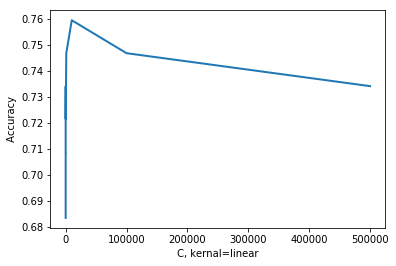

In [51]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 500000], model=SVC()
                , title='C, kernal=linear', kernel='linear', probability=True)

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.6075949367088608, with C = 0.01


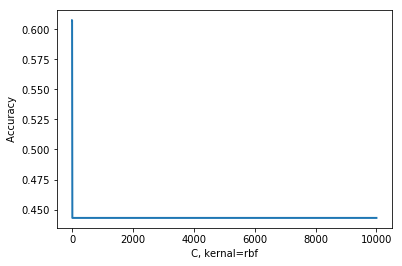

In [52]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=SVC()
                , title='C, kernal=rbf', gamma=1, kernel='rbf', probability=True)

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.6075949367088608, with gamma = 1


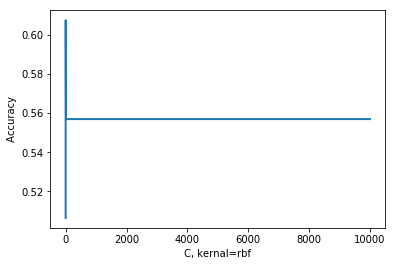

In [53]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='gamma'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=SVC()
                , title='C, kernal=rbf', C=0.01, kernel='rbf', probability=True)

### Result : C = 10000, kernel = 'linear'

### XGBClassifier

Progress = 5.0%
Progress = 10.0%
Progress = 15.0%
Progress = 20.0%
Progress = 25.0%
Progress = 30.0%
Progress = 35.0%
Progress = 40.0%
Progress = 45.0%
Progress = 50.0%
Progress = 55.00000000000001%
Progress = 60.0%
Progress = 65.0%
Progress = 70.0%
Progress = 75.0%
Progress = 80.0%
Progress = 85.0%
Progress = 90.0%
Progress = 95.0%
Progress = 100.0%
max_acc = 0.7848101265822784, with learning_rate = 0.026


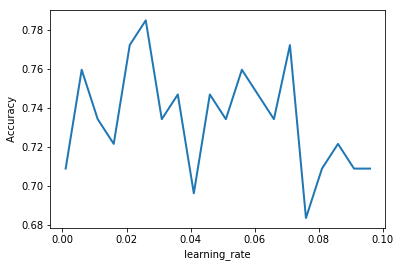

In [134]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[x/1000 for x in range(1, 100, 5)], model=xgb.XGBClassifier()
                , title='learning_rate', max_depth=5, n_estimators=171)

Progress = 1.0%
Progress = 2.0%
Progress = 3.0%
Progress = 4.0%
Progress = 5.0%
Progress = 6.0%
Progress = 7.000000000000001%
Progress = 8.0%
Progress = 9.0%
Progress = 10.0%
Progress = 11.0%
Progress = 12.0%
Progress = 13.0%
Progress = 14.000000000000002%
Progress = 15.0%
Progress = 16.0%
Progress = 17.0%
Progress = 18.0%
Progress = 19.0%
Progress = 20.0%
Progress = 21.0%
Progress = 22.0%
Progress = 23.0%
Progress = 24.0%
Progress = 25.0%
Progress = 26.0%
Progress = 27.0%
Progress = 28.000000000000004%
Progress = 28.999999999999996%
Progress = 30.0%
Progress = 31.0%
Progress = 32.0%
Progress = 33.0%
Progress = 34.0%
Progress = 35.0%
Progress = 36.0%
Progress = 37.0%
Progress = 38.0%
Progress = 39.0%
Progress = 40.0%
Progress = 41.0%
Progress = 42.0%
Progress = 43.0%
Progress = 44.0%
Progress = 45.0%
Progress = 46.0%
Progress = 47.0%
Progress = 48.0%
Progress = 49.0%
Progress = 50.0%
Progress = 51.0%
Progress = 52.0%
Progress = 53.0%
Progress = 54.0%
Progress = 55.00000000000001%
Progr

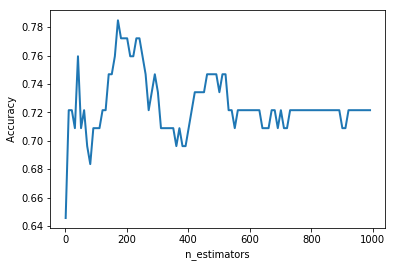

In [135]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=range(1, 1000, 10), model=xgb.XGBClassifier()
                , title='n_estimators', max_depth=5, learning_rate=0.026)

Progress = 6.666666666666667%
Progress = 13.333333333333334%
Progress = 20.0%
Progress = 26.666666666666668%
Progress = 33.33333333333333%
Progress = 40.0%
Progress = 46.666666666666664%
Progress = 53.333333333333336%
Progress = 60.0%
Progress = 66.66666666666666%
Progress = 73.33333333333333%
Progress = 80.0%
Progress = 86.66666666666667%
Progress = 93.33333333333333%
Progress = 100.0%
max_acc = 0.7848101265822784, with max_depth = 5


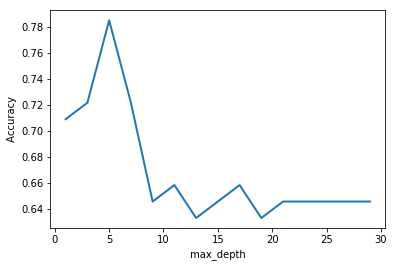

In [136]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], model=xgb.XGBClassifier()
                , title='max_depth', learning_rate=0.026, n_estimators=171)

### Result : max_depth = 5,  learning_rate = 0.026, n_estimators=171

### RandomForestClassifier

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.6582278481012658, with max_depth = 1000


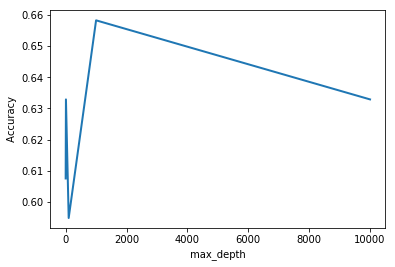

In [68]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 10, 100, 1000, 10000], model=RandomForestClassifier()
                , title='max_depth', criterion='entropy', n_estimators=51)

Progress = 2.5%
Progress = 5.0%
Progress = 7.5%
Progress = 10.0%
Progress = 12.5%
Progress = 15.0%
Progress = 17.5%
Progress = 20.0%
Progress = 22.5%
Progress = 25.0%
Progress = 27.500000000000004%
Progress = 30.0%
Progress = 32.5%
Progress = 35.0%
Progress = 37.5%
Progress = 40.0%
Progress = 42.5%
Progress = 45.0%
Progress = 47.5%
Progress = 50.0%
Progress = 52.5%
Progress = 55.00000000000001%
Progress = 57.49999999999999%
Progress = 60.0%
Progress = 62.5%
Progress = 65.0%
Progress = 67.5%
Progress = 70.0%
Progress = 72.5%
Progress = 75.0%
Progress = 77.5%
Progress = 80.0%
Progress = 82.5%
Progress = 85.0%
Progress = 87.5%
Progress = 90.0%
Progress = 92.5%
Progress = 95.0%
Progress = 97.5%
Progress = 100.0%
max_acc = 0.7341772151898734, with n_estimators = 121


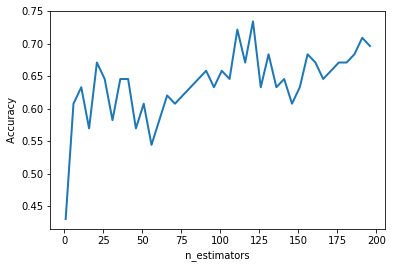

In [71]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=range(1, 200, 5), model=RandomForestClassifier()
                , title='n_estimators', criterion='entropy', max_depth=1000)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.7088607594936709, with max_depth = 1000


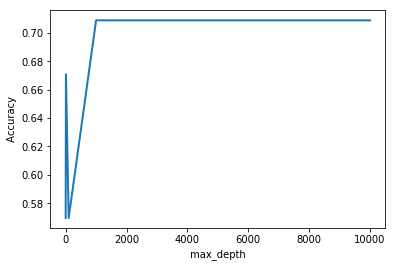

In [77]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 10, 100, 1000, 10000], model=RandomForestClassifier()
                , title='max_depth', criterion='gini', n_estimators=56)

Progress = 2.5%
Progress = 5.0%
Progress = 7.5%
Progress = 10.0%
Progress = 12.5%
Progress = 15.0%
Progress = 17.5%
Progress = 20.0%
Progress = 22.5%
Progress = 25.0%
Progress = 27.500000000000004%
Progress = 30.0%
Progress = 32.5%
Progress = 35.0%
Progress = 37.5%
Progress = 40.0%
Progress = 42.5%
Progress = 45.0%
Progress = 47.5%
Progress = 50.0%
Progress = 52.5%
Progress = 55.00000000000001%
Progress = 57.49999999999999%
Progress = 60.0%
Progress = 62.5%
Progress = 65.0%
Progress = 67.5%
Progress = 70.0%
Progress = 72.5%
Progress = 75.0%
Progress = 77.5%
Progress = 80.0%
Progress = 82.5%
Progress = 85.0%
Progress = 87.5%
Progress = 90.0%
Progress = 92.5%
Progress = 95.0%
Progress = 97.5%
Progress = 100.0%
max_acc = 0.7088607594936709, with n_estimators = 101


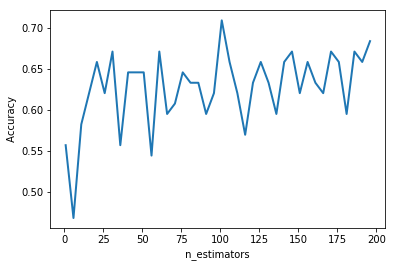

In [78]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=range(1, 200, 5), model=RandomForestClassifier()
                , title='n_estimators', criterion='gini', max_depth=1000)

### Result : criterion='entropy', max_depth=1000, n_estimators=121

### GradientBoostingClassifier

Progress = 1.25%
Progress = 2.5%
Progress = 3.75%
Progress = 5.0%
Progress = 6.25%
Progress = 7.5%
Progress = 8.75%
Progress = 10.0%
Progress = 11.25%
Progress = 12.5%
Progress = 13.750000000000002%
Progress = 15.0%
Progress = 16.25%
Progress = 17.5%
Progress = 18.75%
Progress = 20.0%
Progress = 21.25%
Progress = 22.5%
Progress = 23.75%
Progress = 25.0%
Progress = 26.25%
Progress = 27.500000000000004%
Progress = 28.749999999999996%
Progress = 30.0%
Progress = 31.25%
Progress = 32.5%
Progress = 33.75%
Progress = 35.0%
Progress = 36.25%
Progress = 37.5%
Progress = 38.75%
Progress = 40.0%
Progress = 41.25%
Progress = 42.5%
Progress = 43.75%
Progress = 45.0%
Progress = 46.25%
Progress = 47.5%
Progress = 48.75%
Progress = 50.0%
Progress = 51.24999999999999%
Progress = 52.5%
Progress = 53.75%
Progress = 55.00000000000001%
Progress = 56.25%
Progress = 57.49999999999999%
Progress = 58.75%
Progress = 60.0%
Progress = 61.25000000000001%
Progress = 62.5%
Progress = 63.74999999999999%
Progress = 6

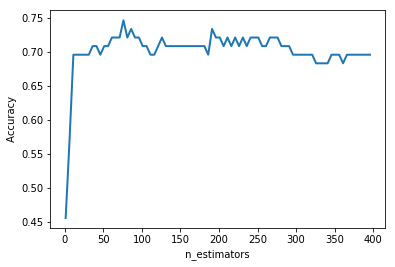

In [86]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=range(1, 400, 5), model=GradientBoostingClassifier()
                , title='n_estimators', max_depth=1, learning_rate=0.1)

Progress = 0.4%
Progress = 0.8%
Progress = 1.2%
Progress = 1.6%
Progress = 2.0%
Progress = 2.4%
Progress = 2.8000000000000003%
Progress = 3.2%
Progress = 3.5999999999999996%
Progress = 4.0%
Progress = 4.3999999999999995%
Progress = 4.8%
Progress = 5.2%
Progress = 5.6000000000000005%
Progress = 6.0%
Progress = 6.4%
Progress = 6.800000000000001%
Progress = 7.199999999999999%
Progress = 7.6%
Progress = 8.0%
Progress = 8.4%
Progress = 8.799999999999999%
Progress = 9.2%
Progress = 9.6%
Progress = 10.0%
Progress = 10.4%
Progress = 10.8%
Progress = 11.200000000000001%
Progress = 11.600000000000001%
Progress = 12.0%
Progress = 12.4%
Progress = 12.8%
Progress = 13.200000000000001%
Progress = 13.600000000000001%
Progress = 14.000000000000002%
Progress = 14.399999999999999%
Progress = 14.799999999999999%
Progress = 15.2%
Progress = 15.6%
Progress = 16.0%
Progress = 16.400000000000002%
Progress = 16.8%
Progress = 17.2%
Progress = 17.599999999999998%
Progress = 18.0%
Progress = 18.4%
Progress = 18.

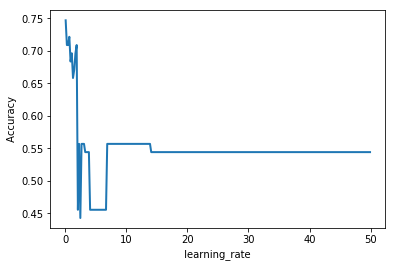

In [87]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[x/100 for x in range(10, 5000, 20)], model=GradientBoostingClassifier()
                , title='learning_rate', n_estimators=76, max_depth=1)

Progress = 5.0%
Progress = 10.0%
Progress = 15.0%
Progress = 20.0%
Progress = 25.0%
Progress = 30.0%
Progress = 35.0%
Progress = 40.0%
Progress = 45.0%
Progress = 50.0%
Progress = 55.00000000000001%
Progress = 60.0%
Progress = 65.0%
Progress = 70.0%
Progress = 75.0%
Progress = 80.0%
Progress = 85.0%
Progress = 90.0%
Progress = 95.0%
Progress = 100.0%
max_acc = 0.7468354430379747, with max_depth = 1


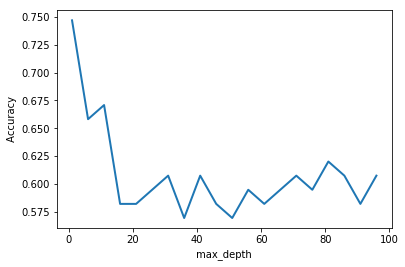

In [89]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=range(1, 100, 5), model=GradientBoostingClassifier()
                , title='max_depth', n_estimators=76, learning_rate=0.1)

### Result : n_estimators=76, learning_rate=0.1, max_depth = 1

### LGBMClassifier

Progress = 1.0%
Progress = 2.0%
Progress = 3.0%
Progress = 4.0%
Progress = 5.0%
Progress = 6.0%
Progress = 7.000000000000001%
Progress = 8.0%
Progress = 9.0%
Progress = 10.0%
Progress = 11.0%
Progress = 12.0%
Progress = 13.0%
Progress = 14.000000000000002%
Progress = 15.0%
Progress = 16.0%
Progress = 17.0%
Progress = 18.0%
Progress = 19.0%
Progress = 20.0%
Progress = 21.0%
Progress = 22.0%
Progress = 23.0%
Progress = 24.0%
Progress = 25.0%
Progress = 26.0%
Progress = 27.0%
Progress = 28.000000000000004%
Progress = 28.999999999999996%
Progress = 30.0%
Progress = 31.0%
Progress = 32.0%
Progress = 33.0%
Progress = 34.0%
Progress = 35.0%
Progress = 36.0%
Progress = 37.0%
Progress = 38.0%
Progress = 39.0%
Progress = 40.0%
Progress = 41.0%
Progress = 42.0%
Progress = 43.0%
Progress = 44.0%
Progress = 45.0%
Progress = 46.0%
Progress = 47.0%
Progress = 48.0%
Progress = 49.0%
Progress = 50.0%
Progress = 51.0%
Progress = 52.0%
Progress = 53.0%
Progress = 54.0%
Progress = 55.00000000000001%
Progr

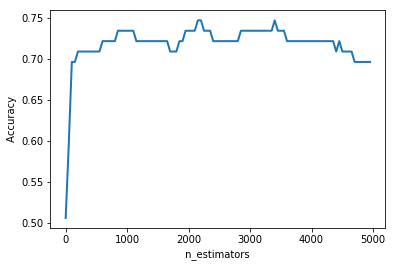

In [105]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=range(1, 5000, 50), model=LGBMClassifier()
                , title='n_estimators', learning_rate=0.01, max_depth=1)

Progress = 1.0%
Progress = 2.0%
Progress = 3.0%
Progress = 4.0%
Progress = 5.0%
Progress = 6.0%
Progress = 7.000000000000001%
Progress = 8.0%
Progress = 9.0%
Progress = 10.0%
Progress = 11.0%
Progress = 12.0%
Progress = 13.0%
Progress = 14.000000000000002%
Progress = 15.0%
Progress = 16.0%
Progress = 17.0%
Progress = 18.0%
Progress = 19.0%
Progress = 20.0%
Progress = 21.0%
Progress = 22.0%
Progress = 23.0%
Progress = 24.0%
Progress = 25.0%
Progress = 26.0%
Progress = 27.0%
Progress = 28.000000000000004%
Progress = 28.999999999999996%
Progress = 30.0%
Progress = 31.0%
Progress = 32.0%
Progress = 33.0%
Progress = 34.0%
Progress = 35.0%
Progress = 36.0%
Progress = 37.0%
Progress = 38.0%
Progress = 39.0%
Progress = 40.0%
Progress = 41.0%
Progress = 42.0%
Progress = 43.0%
Progress = 44.0%
Progress = 45.0%
Progress = 46.0%
Progress = 47.0%
Progress = 48.0%
Progress = 49.0%
Progress = 50.0%
Progress = 51.0%
Progress = 52.0%
Progress = 53.0%
Progress = 54.0%
Progress = 55.00000000000001%
Progr

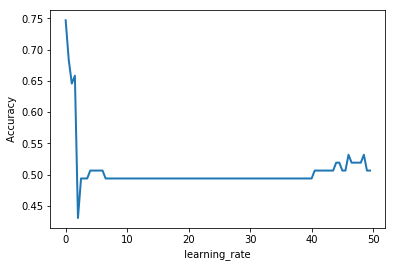

In [106]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[x/100 for x in range(1, 5000, 50)], model=LGBMClassifier()
                , title='learning_rate', n_estimators=2151, max_depth=1)

Progress = 2.0%
Progress = 4.0%
Progress = 6.0%
Progress = 8.0%
Progress = 10.0%
Progress = 12.0%
Progress = 14.000000000000002%
Progress = 16.0%
Progress = 18.0%
Progress = 20.0%
Progress = 22.0%
Progress = 24.0%
Progress = 26.0%
Progress = 28.000000000000004%
Progress = 30.0%
Progress = 32.0%
Progress = 34.0%
Progress = 36.0%
Progress = 38.0%
Progress = 40.0%
Progress = 42.0%
Progress = 44.0%
Progress = 46.0%
Progress = 48.0%
Progress = 50.0%
Progress = 52.0%
Progress = 54.0%
Progress = 56.00000000000001%
Progress = 57.99999999999999%
Progress = 60.0%
Progress = 62.0%
Progress = 64.0%
Progress = 66.0%
Progress = 68.0%
Progress = 70.0%
Progress = 72.0%
Progress = 74.0%
Progress = 76.0%
Progress = 78.0%
Progress = 80.0%
Progress = 82.0%
Progress = 84.0%
Progress = 86.0%
Progress = 88.0%
Progress = 90.0%
Progress = 92.0%
Progress = 94.0%
Progress = 96.0%
Progress = 98.0%
Progress = 100.0%
max_acc = 0.7468354430379747, with max_depth = 1


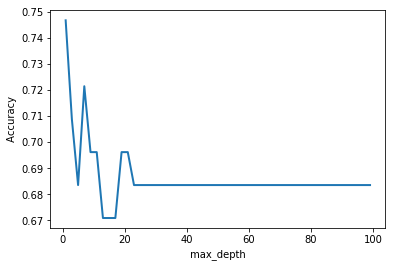

In [108]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=range(1, 100, 2), model=LGBMClassifier()
                , title='max_depth', n_estimators=2151, learning_rate=0.01)

### Result : n_estimators=2151, learning_rate=0.01, max_depth = 1

### AdaBoostClassifier

Progress = 2.5%
Progress = 5.0%
Progress = 7.5%
Progress = 10.0%
Progress = 12.5%
Progress = 15.0%
Progress = 17.5%
Progress = 20.0%
Progress = 22.5%
Progress = 25.0%
Progress = 27.500000000000004%
Progress = 30.0%
Progress = 32.5%
Progress = 35.0%
Progress = 37.5%
Progress = 40.0%
Progress = 42.5%
Progress = 45.0%
Progress = 47.5%
Progress = 50.0%
Progress = 52.5%
Progress = 55.00000000000001%
Progress = 57.49999999999999%
Progress = 60.0%
Progress = 62.5%
Progress = 65.0%
Progress = 67.5%
Progress = 70.0%
Progress = 72.5%
Progress = 75.0%
Progress = 77.5%
Progress = 80.0%
Progress = 82.5%
Progress = 85.0%
Progress = 87.5%
Progress = 90.0%
Progress = 92.5%
Progress = 95.0%
Progress = 97.5%
Progress = 100.0%
max_acc = 0.7721518987341772, with learning_rate = 1.201


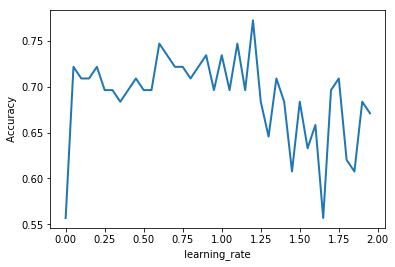

In [120]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[x/1000 for x in range(1, 2000, 50)], model=AdaBoostClassifier()
                , title='learning_rate', n_estimators=120)

Progress = 1.0101010101010102%
Progress = 2.0202020202020203%
Progress = 3.0303030303030303%
Progress = 4.040404040404041%
Progress = 5.05050505050505%
Progress = 6.0606060606060606%
Progress = 7.07070707070707%
Progress = 8.080808080808081%
Progress = 9.090909090909092%
Progress = 10.1010101010101%
Progress = 11.11111111111111%
Progress = 12.121212121212121%
Progress = 13.131313131313133%
Progress = 14.14141414141414%
Progress = 15.151515151515152%
Progress = 16.161616161616163%
Progress = 17.17171717171717%
Progress = 18.181818181818183%
Progress = 19.19191919191919%
Progress = 20.2020202020202%
Progress = 21.21212121212121%
Progress = 22.22222222222222%
Progress = 23.232323232323232%
Progress = 24.242424242424242%
Progress = 25.252525252525253%
Progress = 26.262626262626267%
Progress = 27.27272727272727%
Progress = 28.28282828282828%
Progress = 29.292929292929294%
Progress = 30.303030303030305%
Progress = 31.313131313131315%
Progress = 32.323232323232325%
Progress = 33.3333333333333

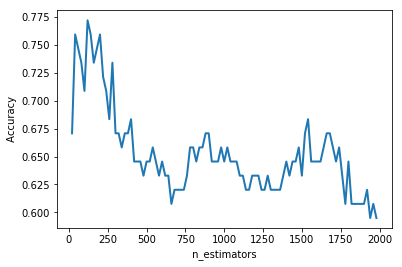

In [123]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=range(20, 2000, 20), model=AdaBoostClassifier()
                , title='n_estimators', learning_rate=1.201)

### Result : learning_rate=1.201, n_estimators = 120

### Classification with optimized parameters

In [138]:
# Model Training
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

logiRegr = LogisticRegression(C = 0.1, max_iter = 6)
logiRegr.fit(X, Y.values.ravel())

supVecMachine = SVC(C = 10000, kernel = 'linear', probability=True)
supVecMachine.fit(X, Y.values.ravel())

xgbc = xgb.XGBClassifier(max_depth = 5,  learning_rate = 0.026, n_estimators=171)
xgbc.fit(X, Y.values.ravel())

naiveBayes = GaussianNB()
naiveBayes.fit(X, Y.values.ravel())

randomForest = RandomForestClassifier(criterion='entropy', max_depth=1000, n_estimators=121)
randomForest.fit(X, Y.values.ravel())

gbdt = GradientBoostingClassifier(n_estimators=76, learning_rate=0.1, max_depth = 1)
gbdt.fit(X,Y.values.ravel())

lgbm = LGBMClassifier(n_estimators=2151, learning_rate=0.01, max_depth = 1)
lgbm.fit(X, Y.values.ravel())

adaBoost = AdaBoostClassifier(learning_rate=1.201, n_estimators = 120)
adaBoost.fit(X, Y.values.ravel())

# Prediction
dateStart = '2018-04-14'
dateEnd = '2018-06-01'
Team_A = None
Team_B = None
modelsLUT = {
    'logiRegr': logiRegr,
    'supVecMachine': supVecMachine,
    'xgbc': xgbc,
    'naiveBayes': naiveBayes,
    'randomForest': randomForest,
    'gbdt': gbdt,
    'lgbm': lgbm, 
    'adaBoost': adaBoost
}

# W/L prediction
gamePrediction(dfFile, modelsLUT, dateStart, dateEnd, period, Team_A, Team_B, featureSel, 1)

---------- Prediction Accuracy ----------
featureSel = 3
logiRegr = 69.62025316455697 %
supVecMachine = 75.9493670886076 %
xgbc = 78.48101265822784 %
naiveBayes = 60.75949367088608 %
randomForest = 63.29113924050633 %
gbdt = 74.68354430379746 %
lgbm = 74.68354430379746 %
adaBoost = 77.21518987341773 %
------------------------------------


{'adaBoost': 0.7721518987341772,
 'gbdt': 0.7468354430379747,
 'lgbm': 0.7468354430379747,
 'logiRegr': 0.6962025316455697,
 'naiveBayes': 0.6075949367088608,
 'randomForest': 0.6329113924050633,
 'supVecMachine': 0.759493670886076,
 'xgbc': 0.7848101265822784}

## Comparison Result
    - 1. The best classification algorithm for this task is XGBClassifier. It has the accuracy up to 78.48%. The worst classification algoruthm for this task is GaussianNB with only accuracy of 60.76%.
    - 2. The parameter tunning improvement compared with the default parameters of each classifation algorithm are as listed below : 
        LogisticRegression     :  69.62% -> 69.62%
        SVC                    :  70.89% -> 75.95%
        XGBClassifier          :  74.68% -> 78.48%
        GaussianNB             :  60.76% -> 60.76%
        RandomForestClassifier :  60.76% -> 63.29%
        LGBMClassifier         :  69.62% -> 74.68%
        AdaBoostClassifier     :  68.35% -> 77.22%
        
        Average Improvement is approximately 3.62%.
        The one that improve the most is AdaBoostClassifier, which is approximately improved by 8.87%.
        The one that improve the least is LogisticRegression and GaussianNB, which is improved by 0%.